In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta as td

In [2]:
US = pd.read_excel('US yield curve.xlsx').set_index('Date')
UK = pd.read_excel('UK yield curve.xlsx').set_index('Date')

# data from the BoE and Fed websites

In [3]:
def run_pca(data,components = 3,fix = [False]*3):
    '''
    applies PCA to a given dataset and produces the explained variance,loadings, and PCs for the desired number 
    of PCs
    The option fix arguments allows for changing the sign on a particular PC for better presentation, since
    eigenvectors are non-unique
    '''
    
    df = data.sub(data.mean())
    eigval,eigvec = np.linalg.eig(df.cov())
    
    prop_exp = pd.DataFrame(pd.DataFrame({'Eigenvalues':eigval,'Explained Proportion': eigval/np.sum(eigval)}))
    loadings = pd.DataFrame(eigvec[:,:components].T,index = ['PC1','PC2','PC3'],columns = df.columns)
    
    for i,idx in enumerate(loadings.index):
        if fix[i]:
            loadings.loc[idx] *= -1
    
    pcs = df.dot(loadings.T)
    
    return prop_exp, loadings, pcs

def plot_proportion(ep,ecy):
   
    plt.figure(figsize=(15,8))
    plt.bar(range(1,ep.shape[0]+1), ep, edgecolor = 'k' )
    plt.title(f'PROPORTION OF VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT ({ecy.upper()})')
    plt.ylabel('Proportion')
    plt.xlabel('Principal Components')
    plt.show()
    
def plot_loadings(loading):
    
    clr = ['b','g','r']
    fig, axes = plt.subplots(nrows = 3, ncols = 1)

    plt.subplots_adjust(left=0, right=2)
    plt.subplots_adjust(bottom=0, top=4)
    
    ticks = loading.columns
    
    for i,ax in enumerate(axes):
        ax.bar(ticks, loading.iloc[i] , color = clr[i], edgecolor = 'k')
        ax.set_title(f'LOADINGS FOR {loading.index[i]}')
        ax.set_xlabel('Tenor')
        ax.set_ylabel('Loading')

    plt.show()
    
def plot_pc(pcs,comp =[None]*3):
    NoneType = type(None)
    
    clr = ['b','g','r']
    fig,axes = plt.subplots(nrows = 3, ncols = 1)
    plt.subplots_adjust(left=0, right=2)
    plt.subplots_adjust(bottom=0, top=4)
    
    for i,ax in enumerate(axes):
        pc = pcs[pcs.columns[i]]
        ax.plot(pc,color = clr[i])
        ax.plot(pcs.index,np.zeros_like(pc), color = 'k')
        ax.set_title(f'DEMEANED {pcs.columns[i]}')
        if type(comp[i]) != NoneType:
            ax.plot(comp[i], color = 'grey')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')

    plt.show()
    
def plot_proportion_compare(pre,post,ecy):
    fig,ax1 = plt.subplots(1,1)

    plt.subplots_adjust(left=0, right=2)
    plt.subplots_adjust(bottom=0, top=2)

    x = np.arange(1,pre.shape[0] + 1)

    ax1.bar(x - 0.2 , pre, edgecolor = 'k', width = 0.4, label = 'Pre-COVID' )
    ax1.bar(x + 0.2, post, edgecolor = 'k', width = 0.4, label = 'Post-COVID' )

    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Proportion')
    ax1.set_title(f'PROPORTION OF VARIANCE EXPLAINED BY EACH PRINCIPAL COMPONENT{ecy.upper()})')
    ax1.set_xticks(x)
    ax1.legend()


    plt.show()
    
def plot_loadings_compare(pre,post):
    
    clr = [('b','darkblue'),('g','darkgreen'),('r','darkred')]
    fig,axes = plt.subplots(nrows = 3, ncols = 1)

    plt.subplots_adjust(left=0, right=2)
    plt.subplots_adjust(bottom=0, top=4)
    
    l = list(pre.columns)
    x = np.arange(1,9)
    for i,ax in enumerate(axes):
        ax.bar(x - 0.2, pre.iloc[i], color = clr[i][0], edgecolor = 'k',width = 0.4, label = 'Pre-COVID')
        ax.bar(x + 0.2, post.iloc[i], color = clr[i][1], edgecolor = 'k',width = 0.4, label = 'Post-COVID')
        ax.set_title(f'LOADINGS FOR {pre.index[i]}')
        ax.set_xlabel('Tenor')
        ax.set_ylabel('Loading')
        ax.set_xticks(x,l)
        ax.legend()

    plt.show()
    
def plot_pc_compare(full,part,pre = True):
    
    clr = [('darkblue','cyan'),('green','olive'),('r','pink')]
    fig,axes = plt.subplots(nrows = 3, ncols = 1)

    plt.subplots_adjust(left=0, right=2)
    plt.subplots_adjust(bottom=0, top=4)
    
    if pre:
        b_or_a = full[:covid - td(1)]
        part_label = 'Pre-COVID Sample'
        
    else:
        b_or_a = full[covid:]
        part_label = 'Post-COVID Sample'
        
    for i,ax in enumerate(axes):
        col = part.columns[i]
        ax.plot(b_or_a[col], color = clr[i][0],label = 'Full Sample')
        ax.plot(part[col], color = clr[i][1],label = part_label)
        ax.plot(part.index,np.zeros_like(part[col]), color = 'k')
        ax.set_title(f'DEMEANED {part.columns[i]}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend()

    plt.show()

## PCA FOR US (Full Sample)

In [4]:
ep_us_0, load_us_0, pc_us_0= run_pca(US,fix=[True,False,True]) 

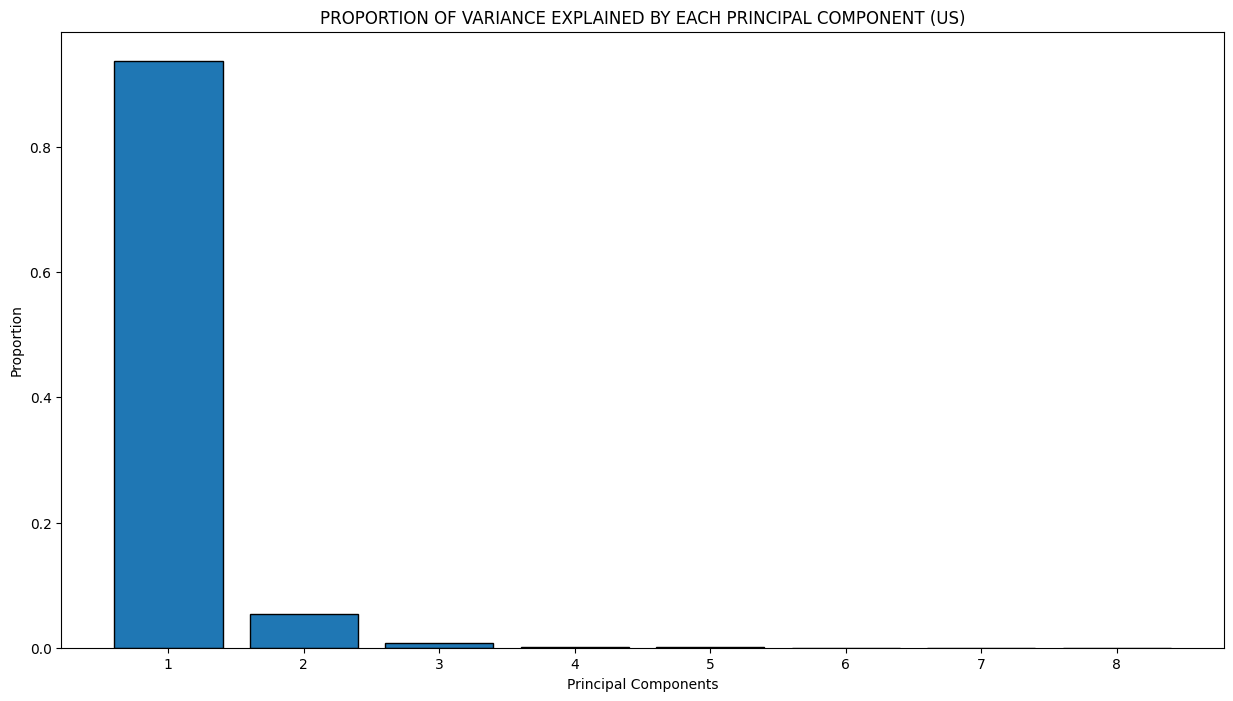

In [5]:
plot_proportion(ep_us_0['Explained Proportion'],'us')

We will only focus on the first 3 PCs, as they explain 99.82% of yield curve movement

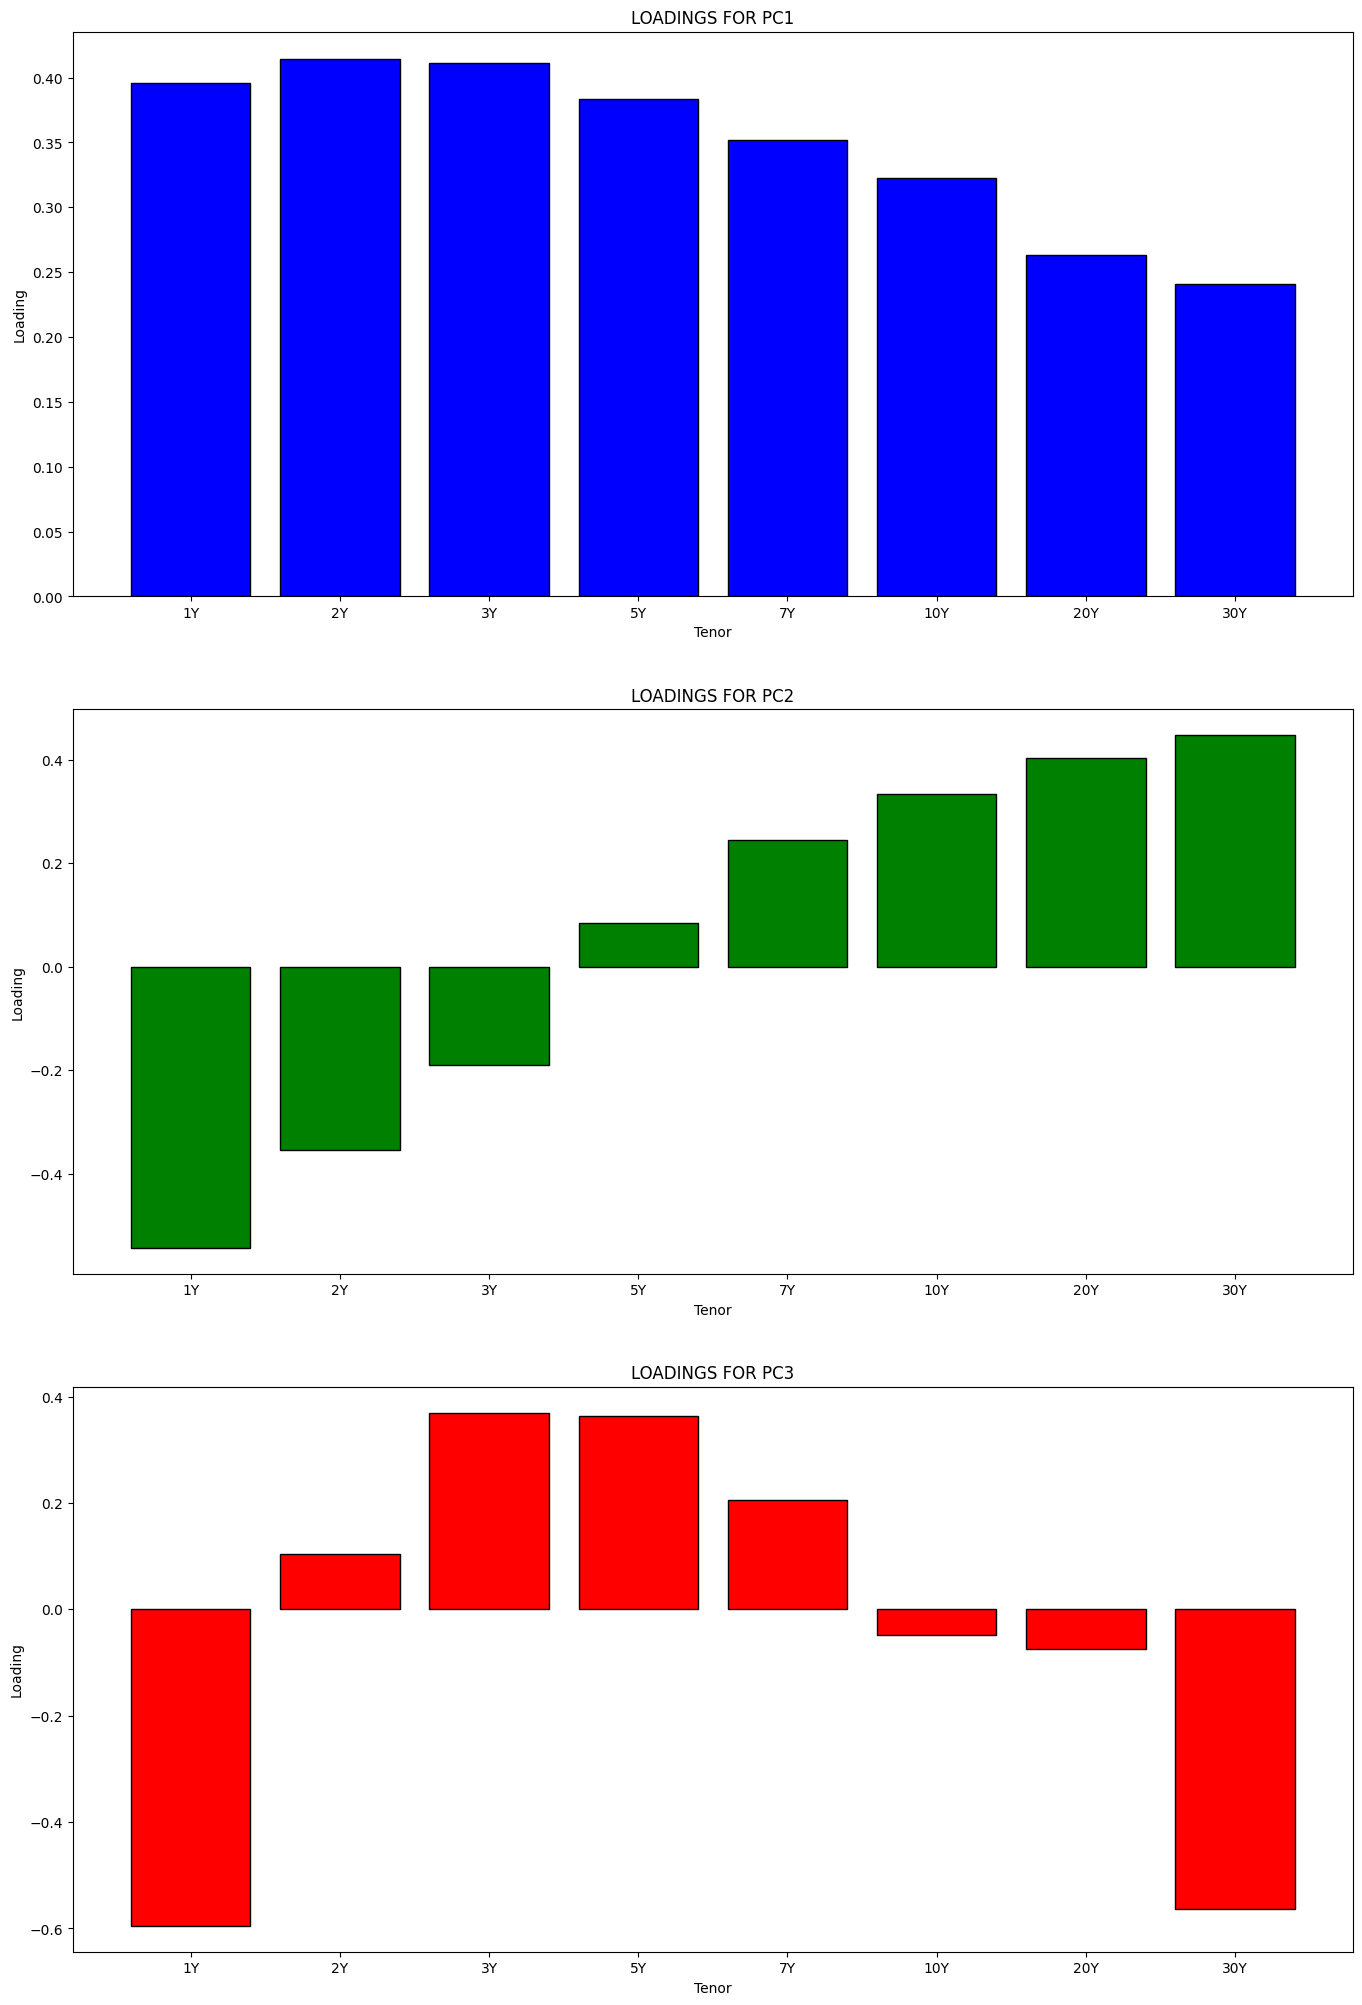

In [6]:
plot_loadings(load_us_0)

As expected, the PCs have intuitive interpretations,
- PC1: level of the yield curve (affects all tenors similarly)
- PC2: slope of the yield curve  (opposite effect on lower and higher tenors)
- PC3: curvature of the yield curve  (similar effect on lower and higher tenors, opposite effect on medium tenors)

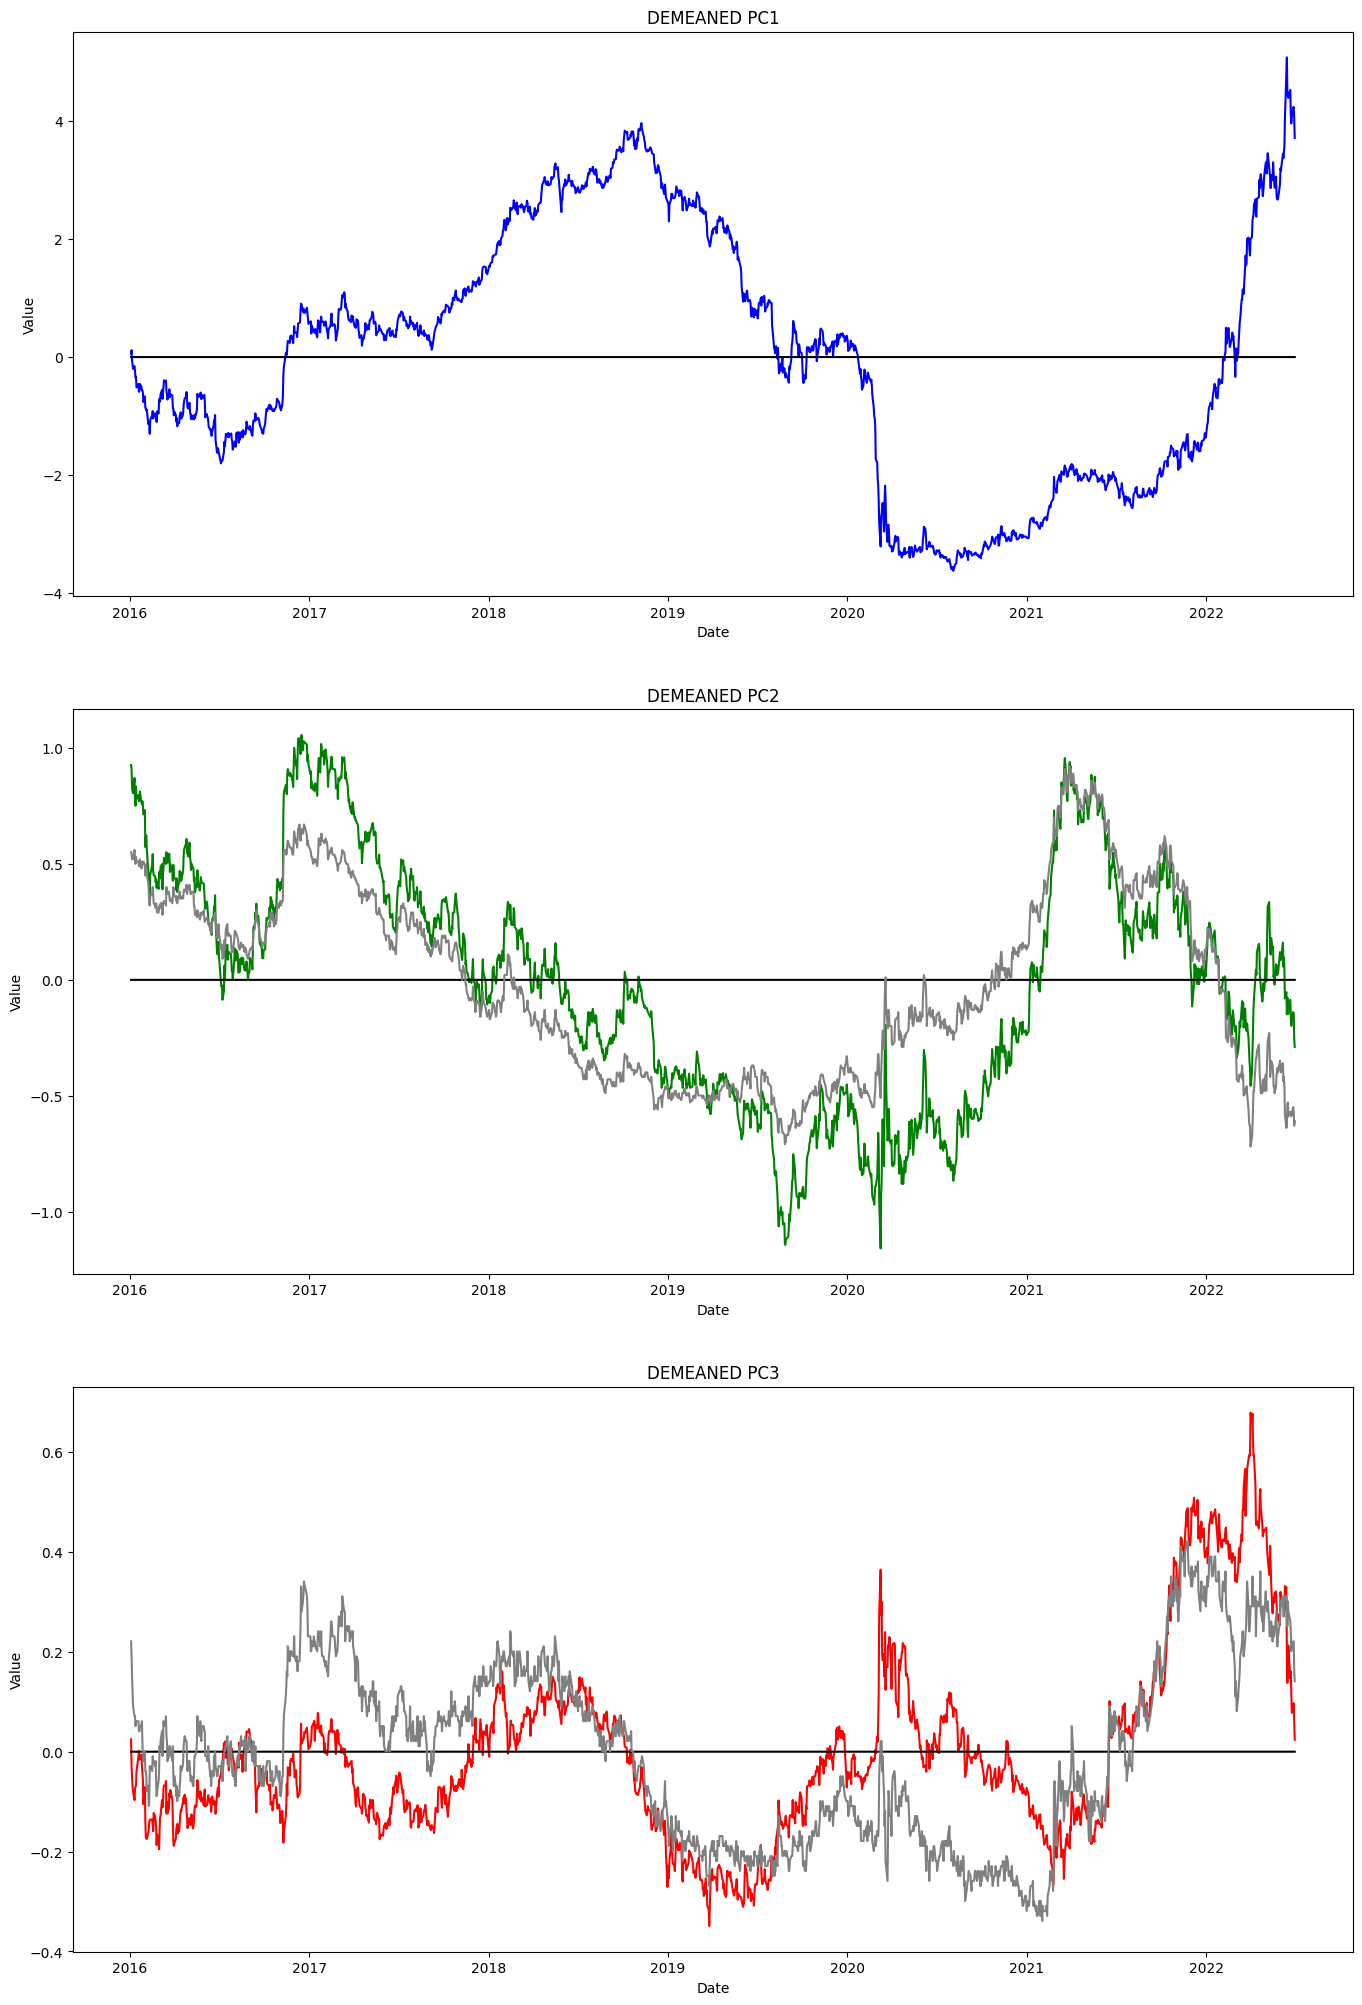

In [7]:
us_2s10s = US['10Y'] - US['2Y']
us_2s5s10s = 2*US['5Y']-US['10Y'] - US['2Y']
plot_pc(pc_us_0,comp=[None,us_2s10s.sub(us_2s10s.mean()),us_2s5s10s.sub(us_2s5s10s.mean())])

The grey line in panel 2 is the term spread, i.e., 10Y - 2Y, while the grey line in panel 3 is a 2Y-5Y-10Y butterfly spread. We can see the close similarity of these spreads with the principal components of slope and curvature respectively.

The first PC seems to proxy the central bank policy, with a sharp dip during the onset of the pandemic and a steep rise in combat of inflation 


## PCA FOR UK (full sample)

In [8]:
ep_uk_0, load_uk_0, pc_uk_0= run_pca(UK,fix=[True,False,True]) 

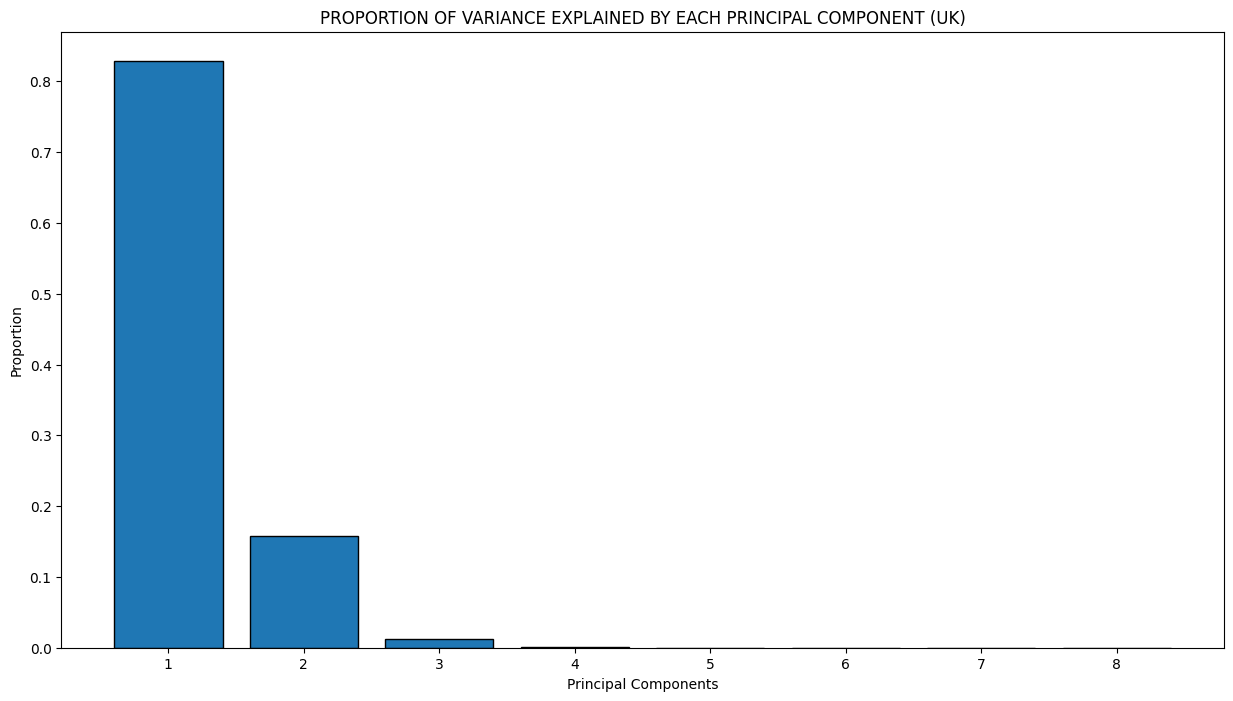

In [9]:
plot_proportion(ep_uk_0['Explained Proportion'],'uk')

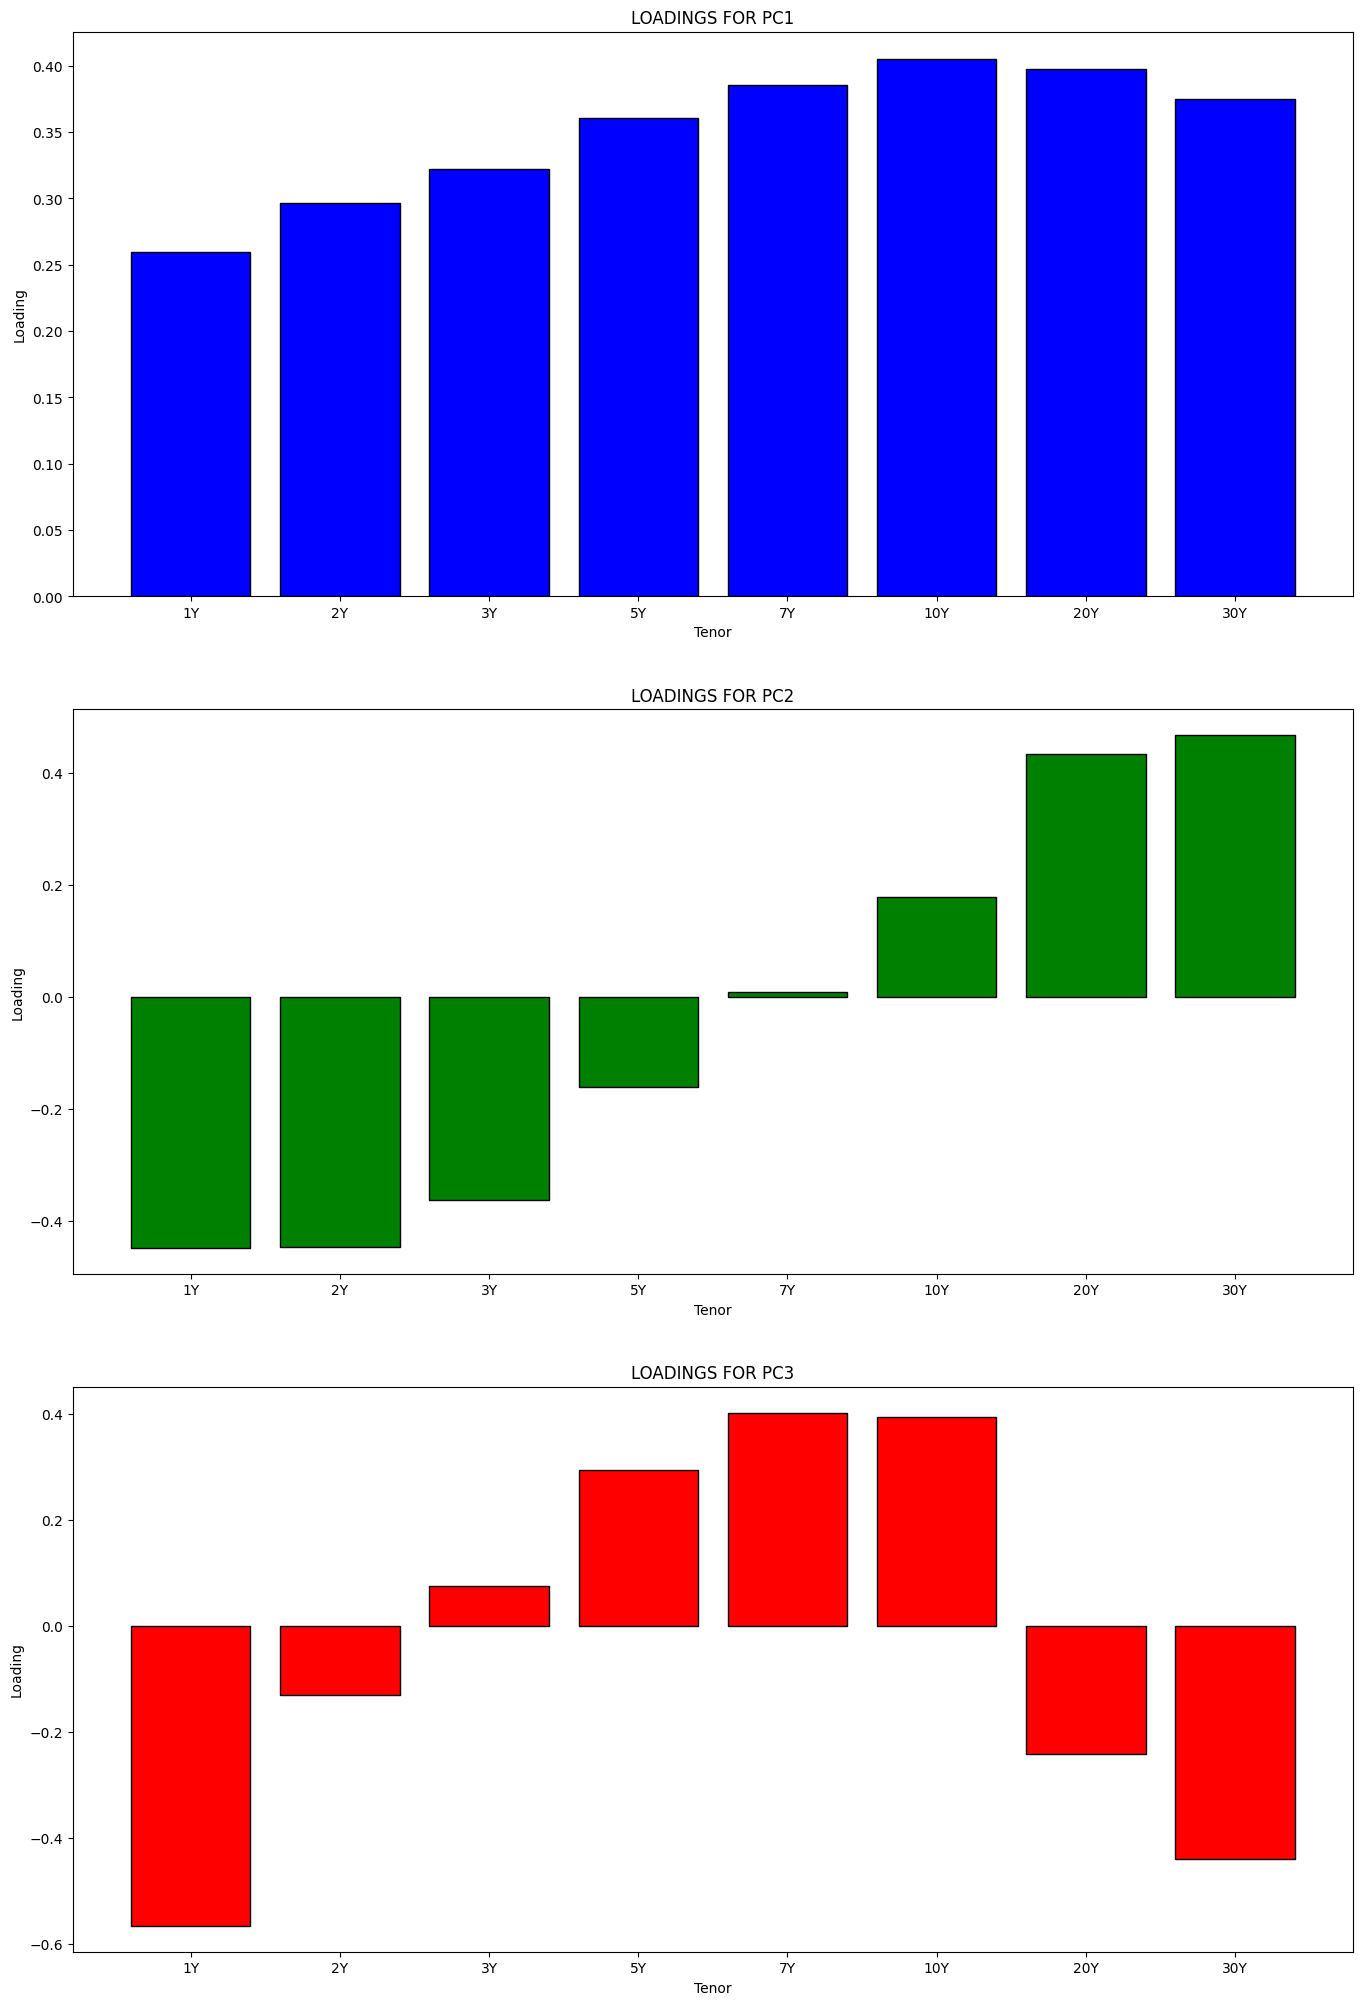

In [10]:
plot_loadings(load_uk_0)

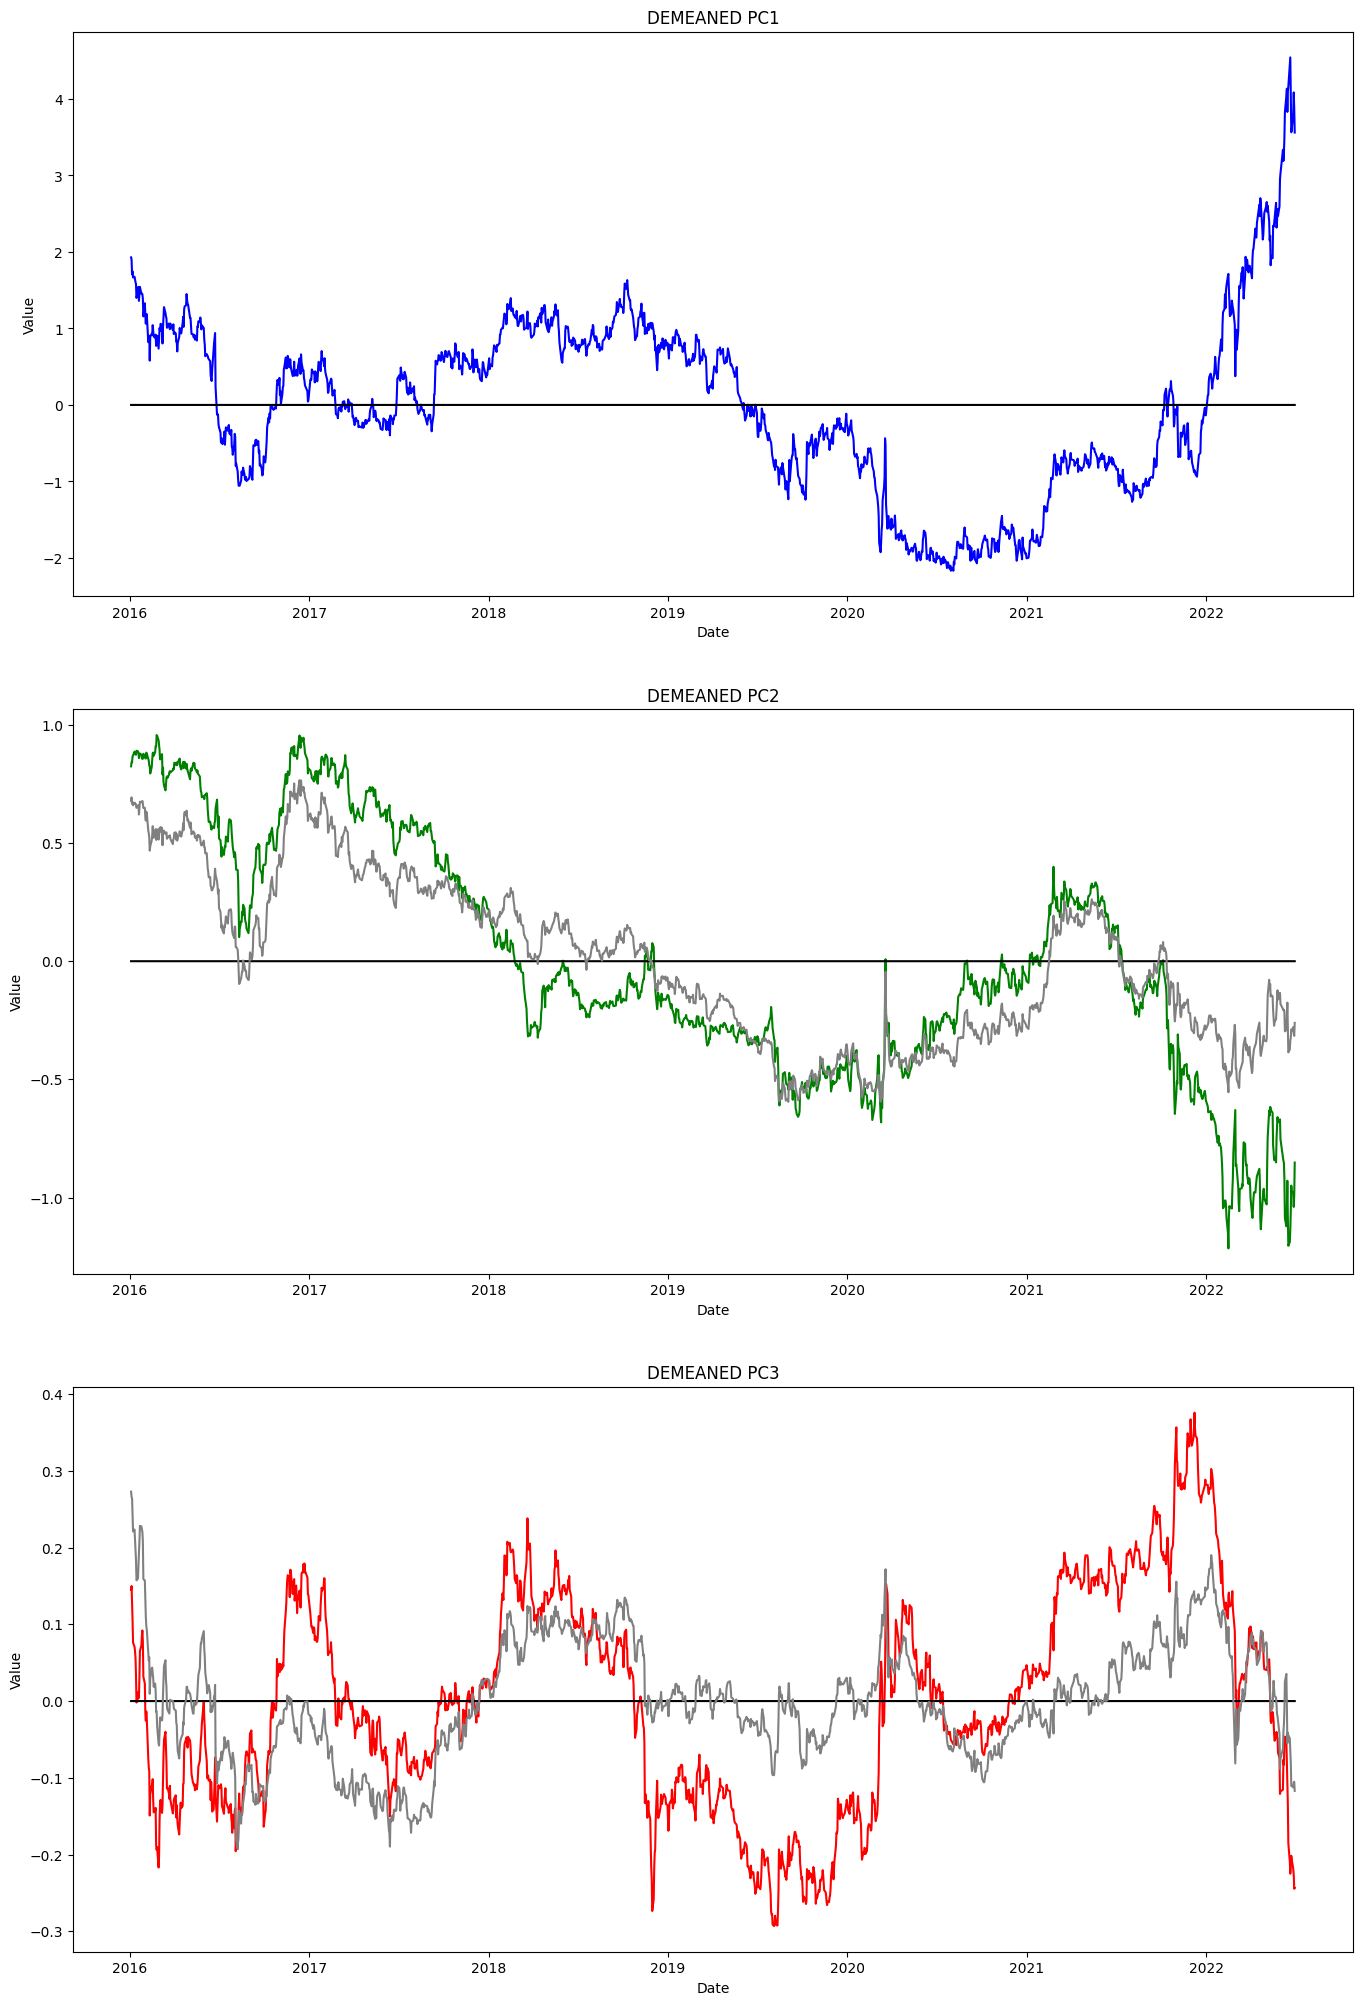

In [11]:
uk_2s10s = UK['10Y'] - UK['2Y']
uk_2s5s10s = 2*UK['5Y']-UK['10Y'] - UK['2Y']
plot_pc(pc_uk_0,comp=[None,uk_2s10s.sub(uk_2s10s.mean()),uk_2s5s10s.sub(uk_2s5s10s.mean())])


PCs 2 and 3 explain almost 3 times more variation in the yield curve of UK versus US

Observing the factor loadings, shorter tenors are more sensitive to PC1 in  US yield curve, whereas longer tenors are more sensitive to PC1 in the UK yield curve. Sensitivity of shorter tenors is symptomatic of an active central bank, moving the yield curve. This can be confirmed by the following graph comparing the Fed Funds rate to the UK bank rate



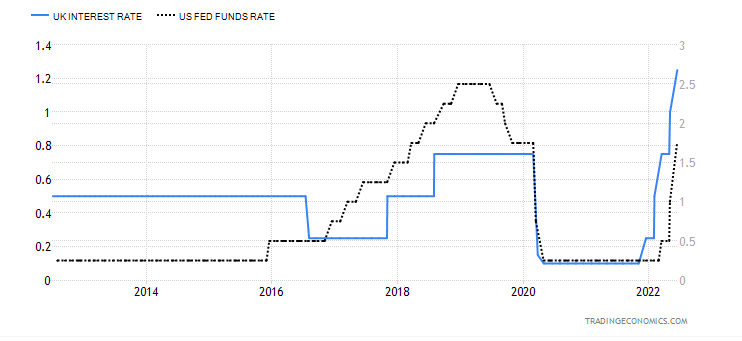

In [12]:
from IPython.display import display, Image
display(Image(filename='rates.png'))

# LHS is the scale for UK, RHS for US

The market has gone through significant structural changes over the period of we are studying, with the pandemic accomodation and then inflation-hawkishness thereafter. Hence it would be sensible to study the sample pre- and post-covid. 




In [13]:
# WHO announced COVID as a pandemic on March 11 2020

covid = dt(2020,3,11)



## US (Before and after COVID)

In [14]:
ep_us_1, load_us_1, pc_us_1 = run_pca(US.loc[:covid-td(1)],fix=[True,True,True]) 
ep_us_2, load_us_2, pc_us_2 = run_pca(US.loc[covid:],fix=[True,True,False]) 

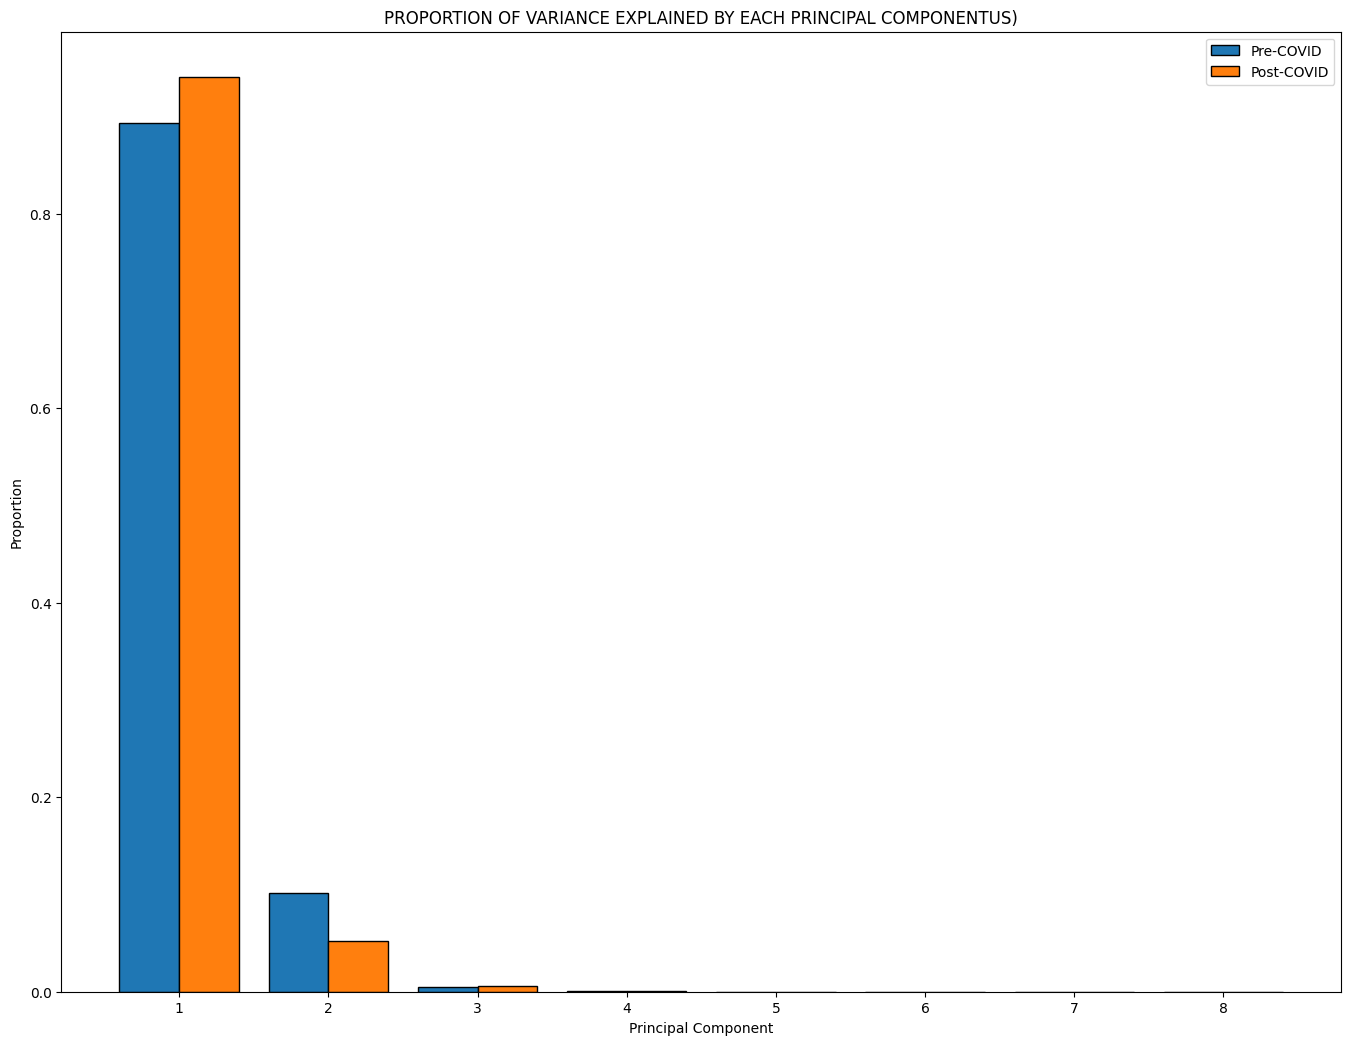

In [15]:
plot_proportion_compare(ep_us_1['Explained Proportion'],ep_us_2['Explained Proportion'],'us')

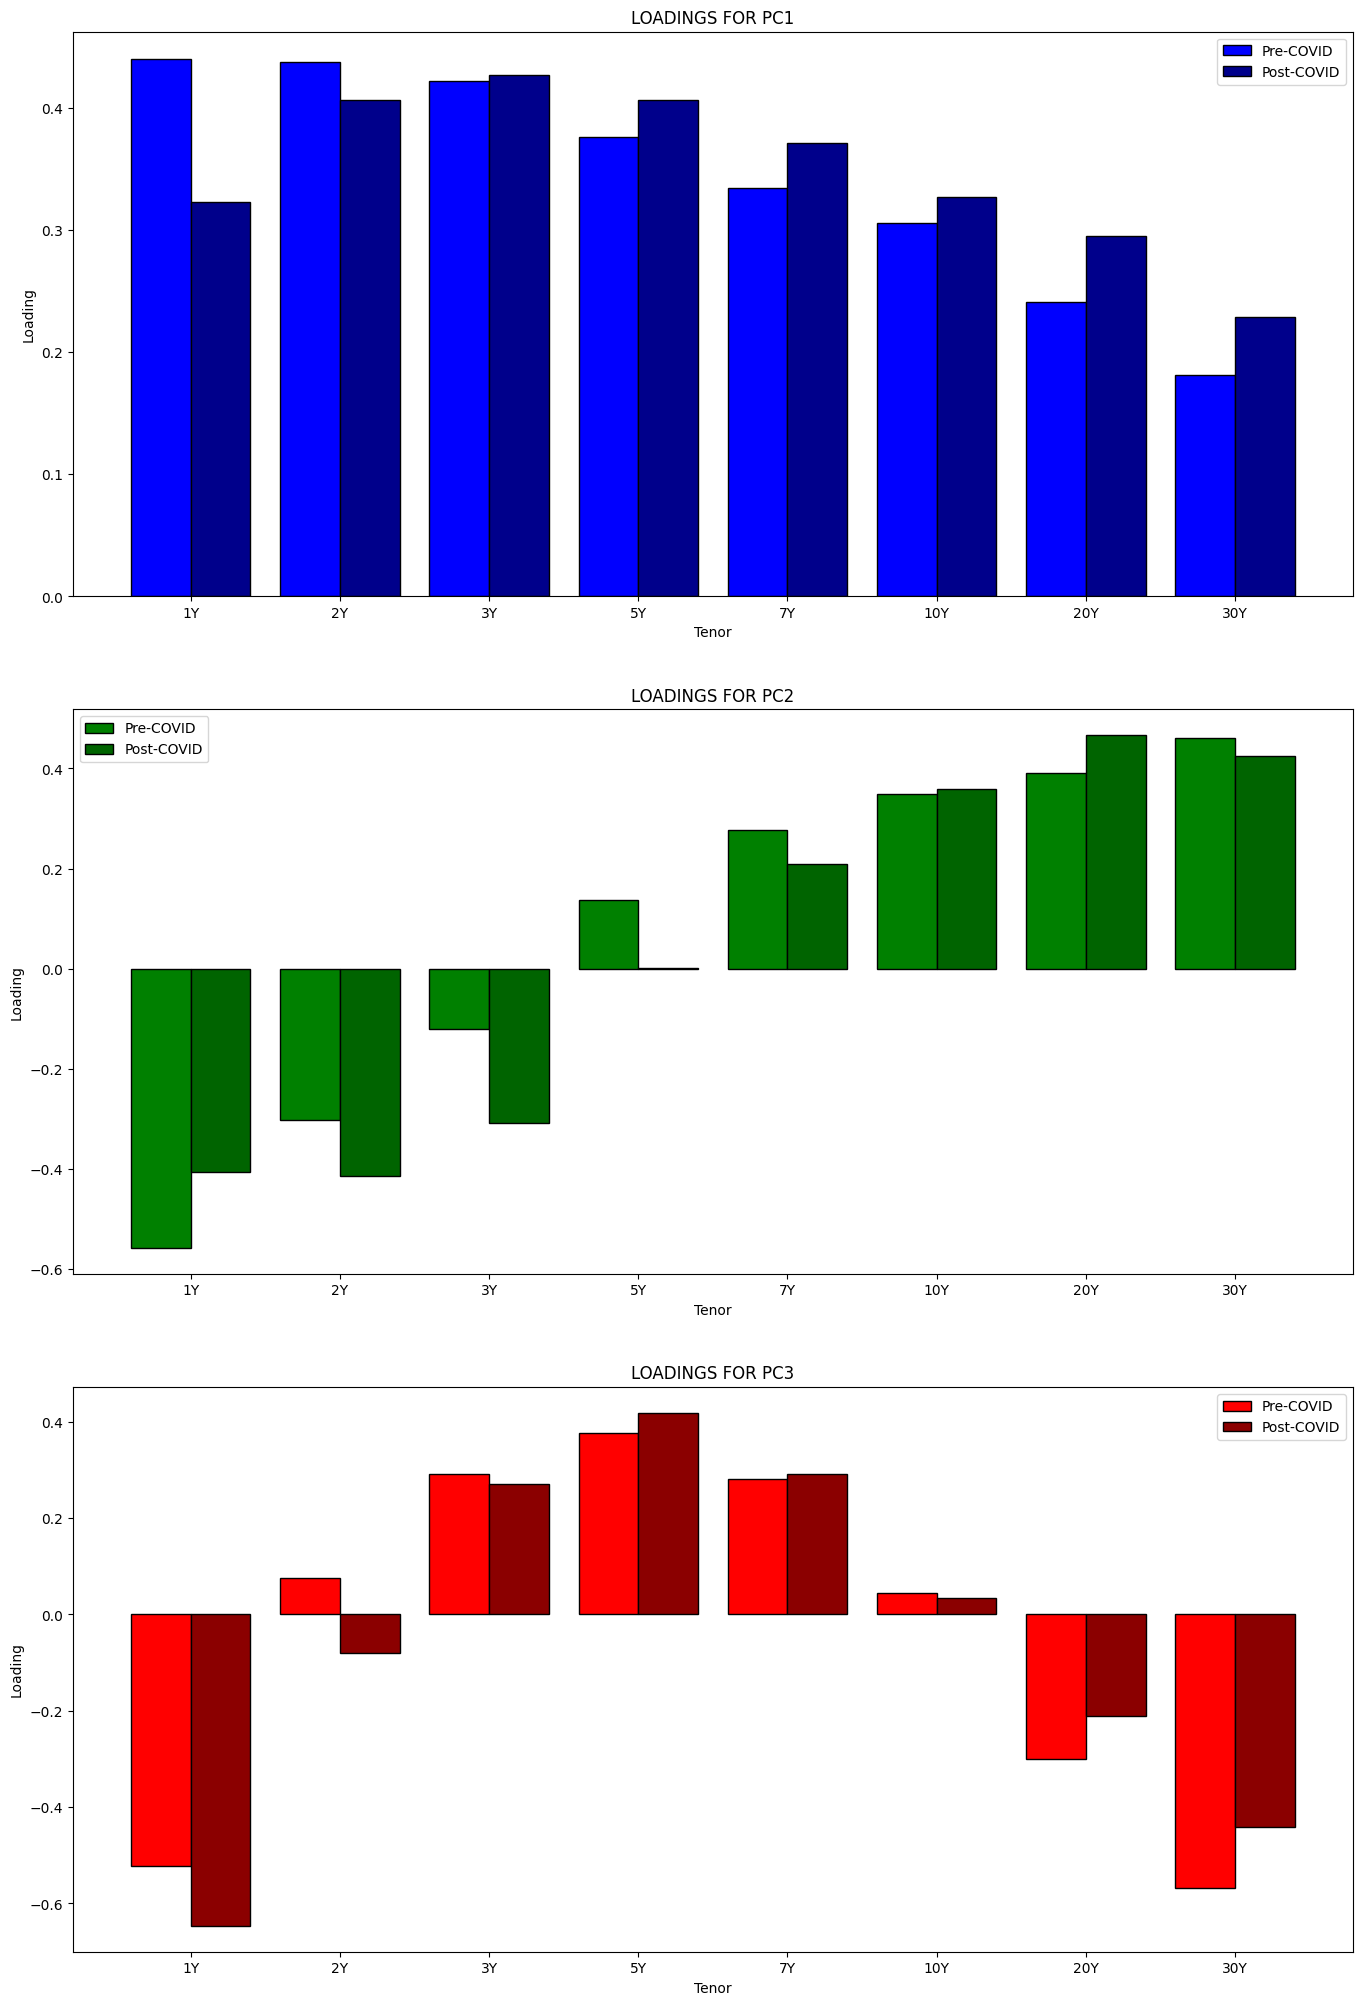

In [16]:
plot_loadings_compare(load_us_1,load_us_2)

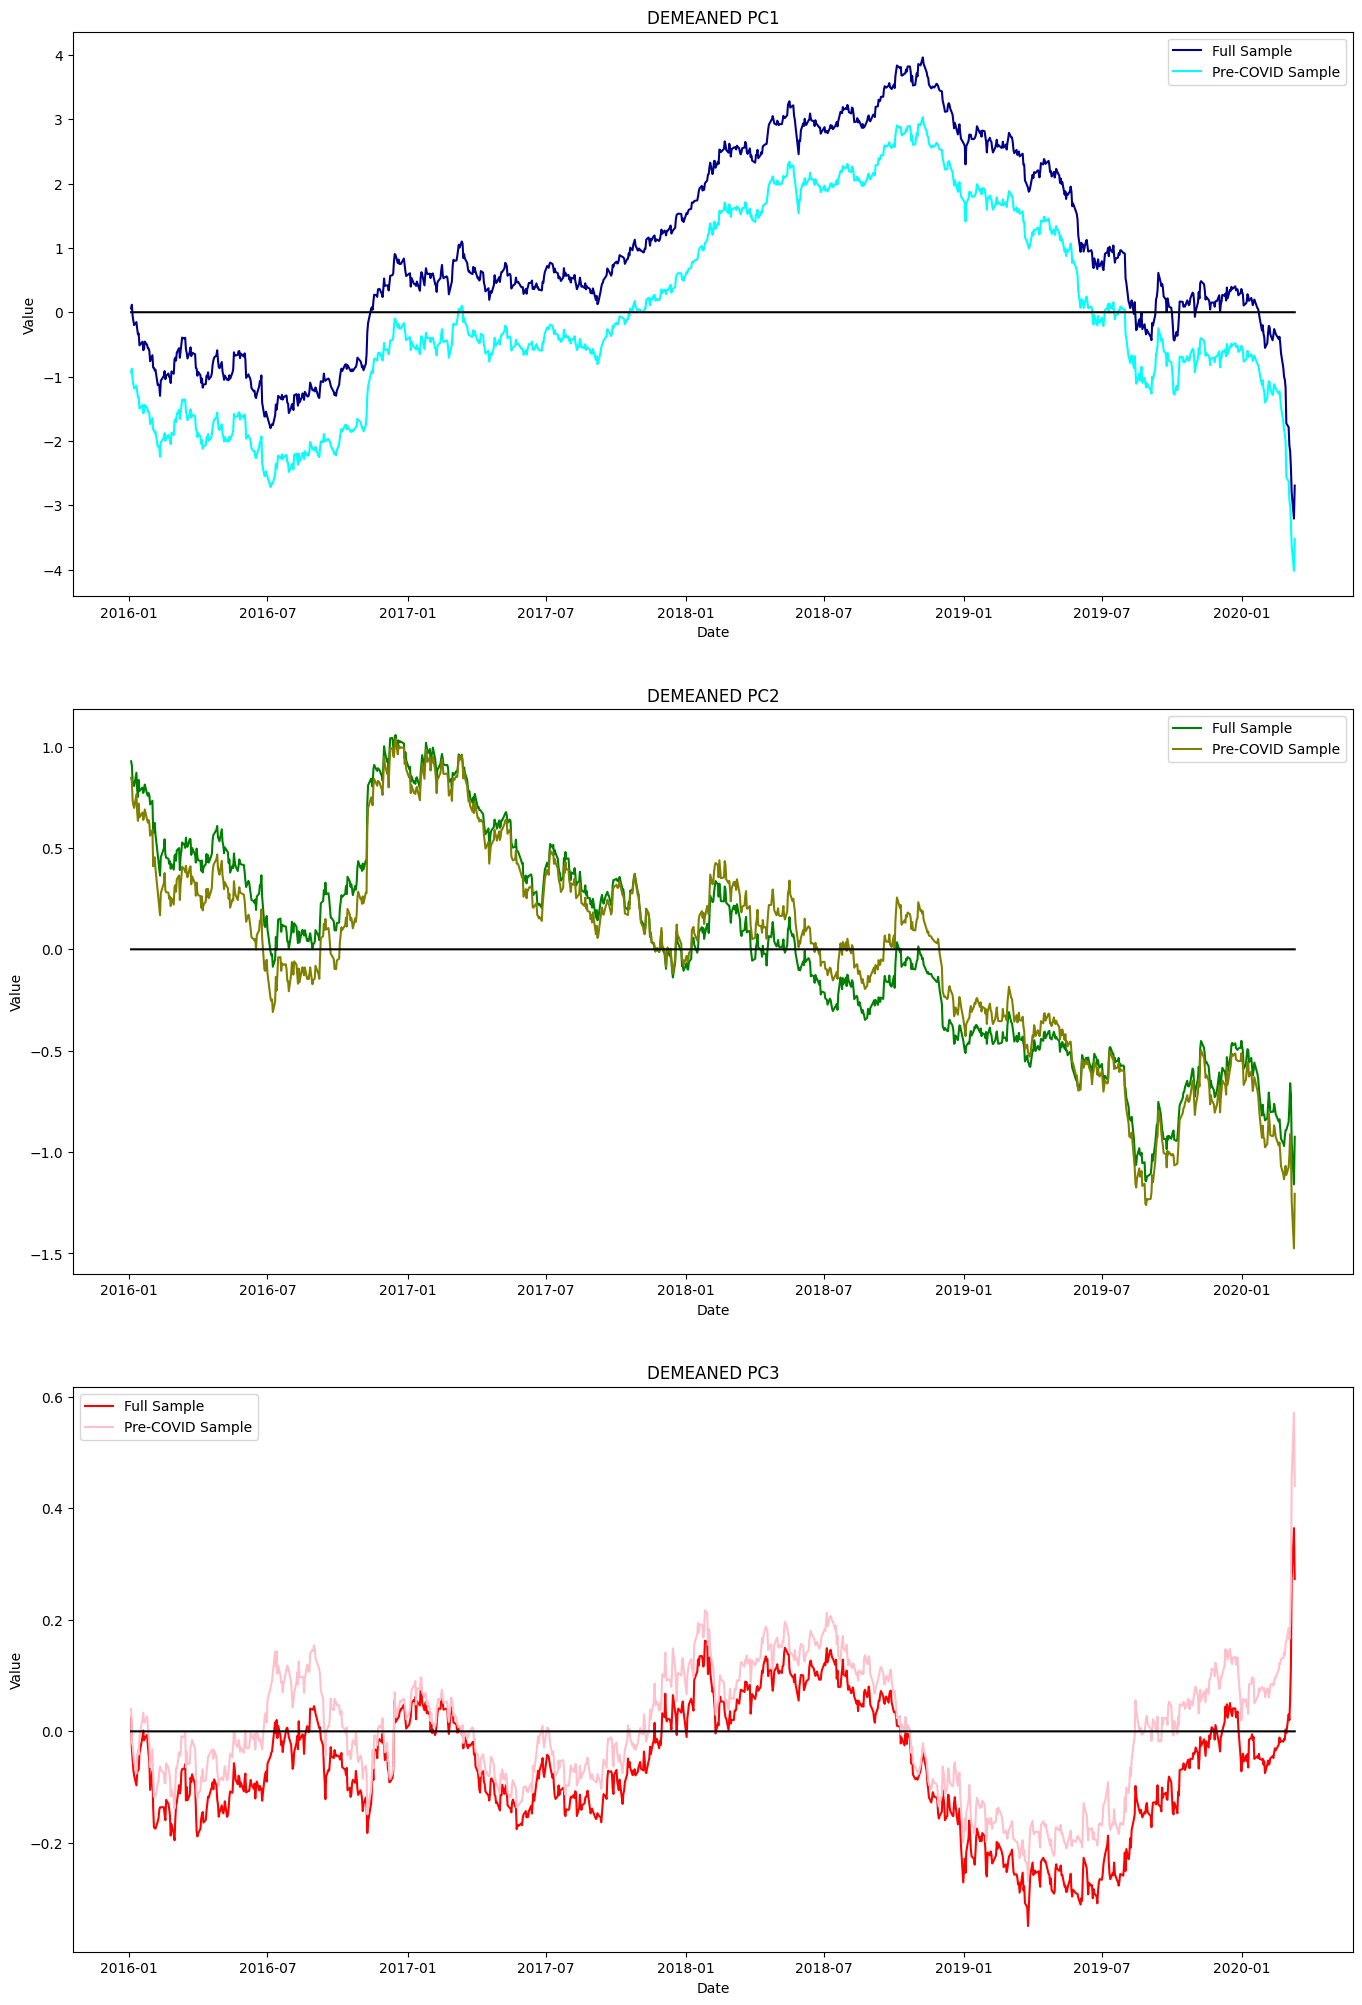

In [17]:
# comparing PC evolution of full and split sample: pre-COVID
plot_pc_compare(pc_us_0,pc_us_1)

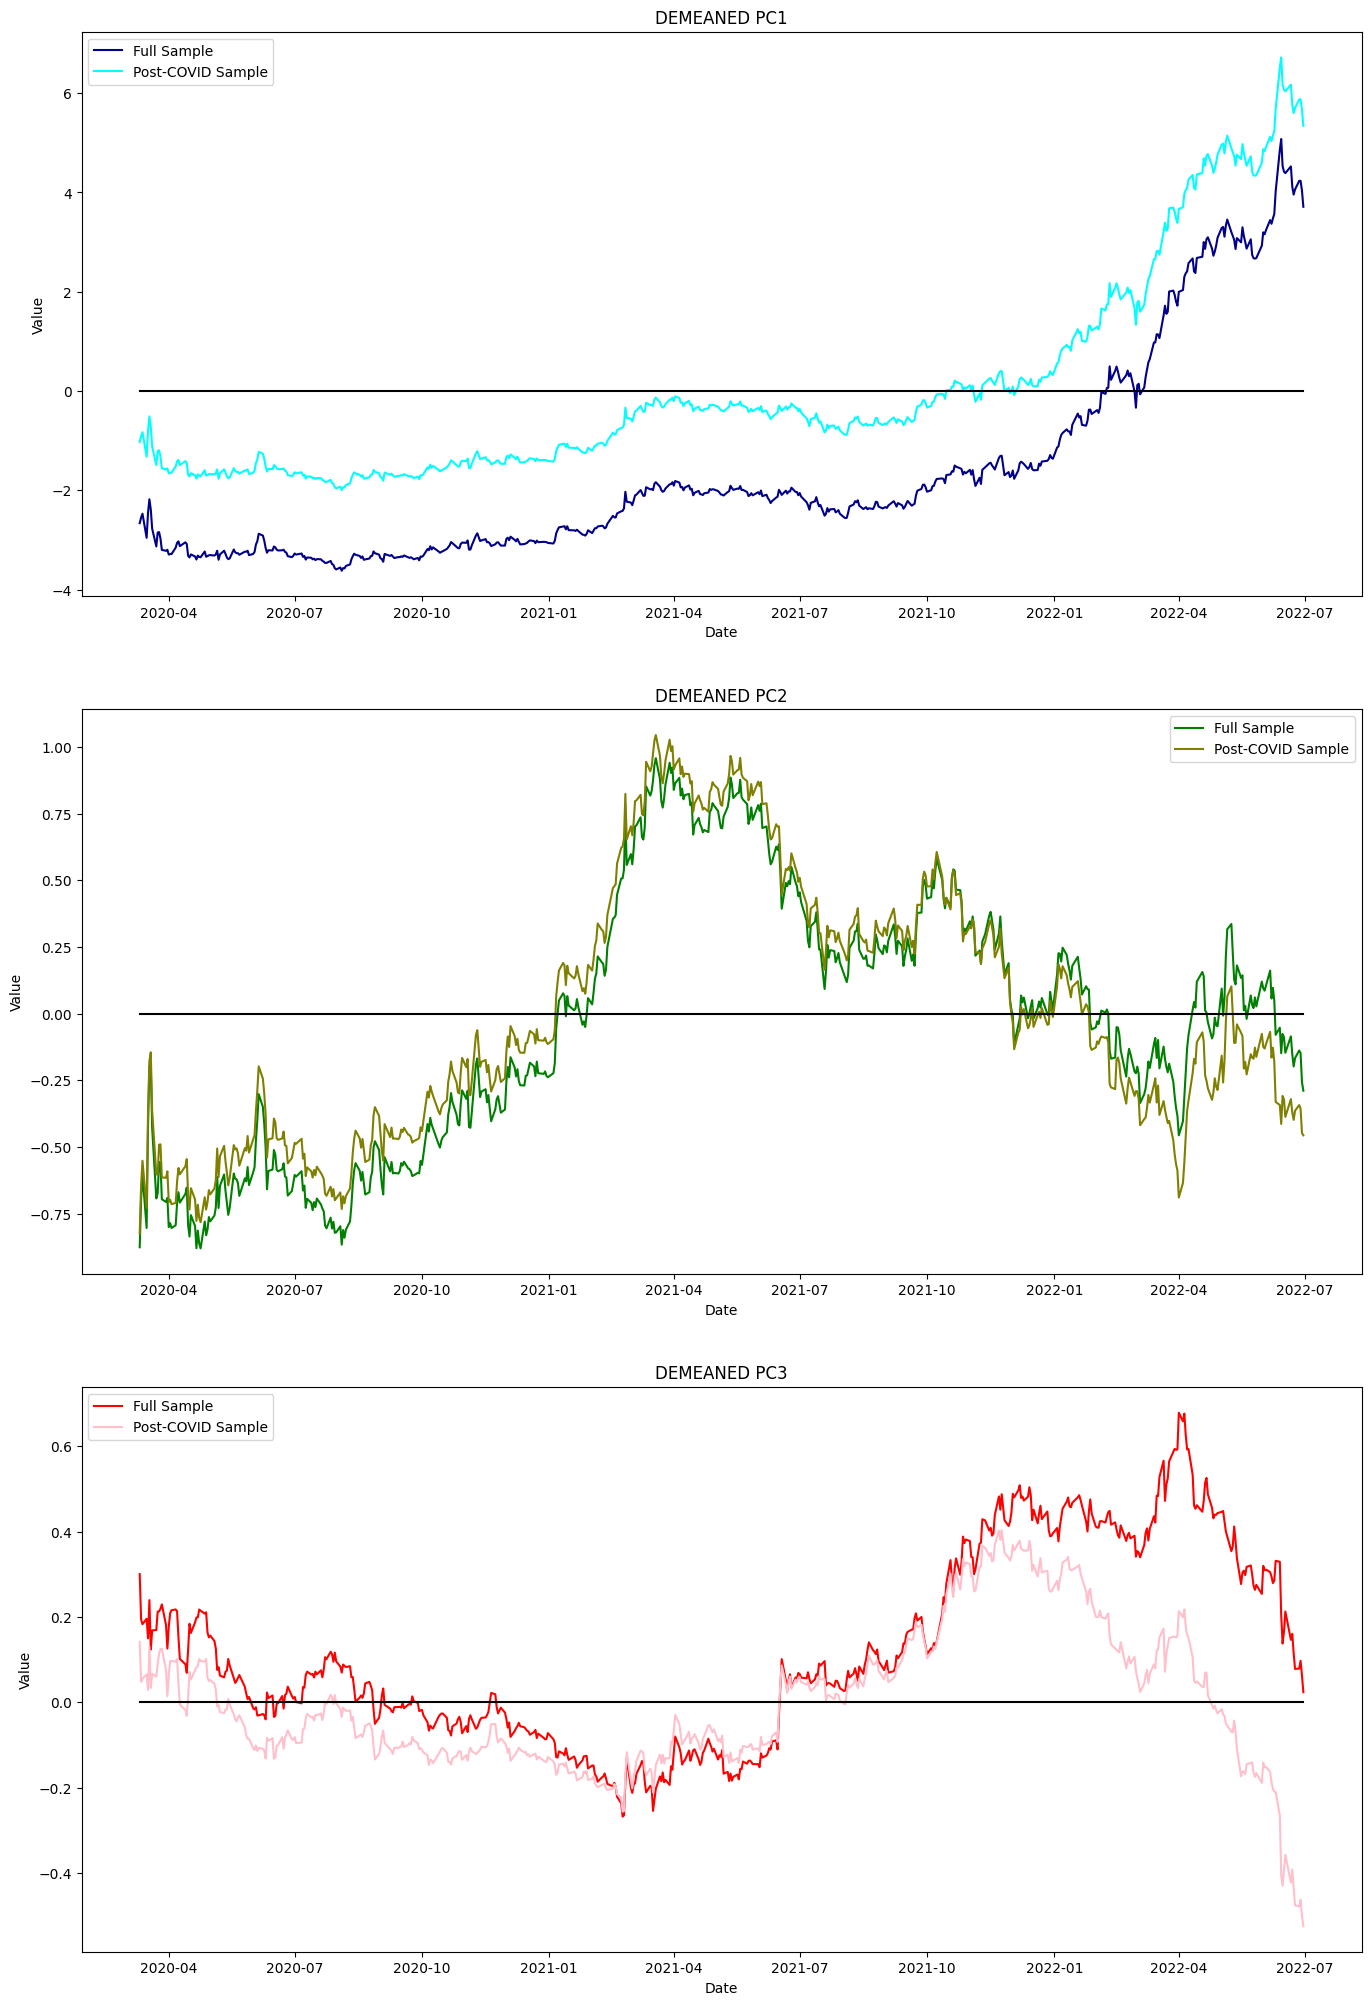

In [18]:
# comparing PC evolution of full and split sample: post-COVID
plot_pc_compare(pc_us_0,pc_us_2,pre = False)

- Eigenvectors are not stable through time, and differ significantly for certain tenors such long and short end of the yield curve for PC1, and flip sign for 2Y and 10Y for PC3
- Full sample and split sample PCs have an increasing discrepancy in $i \in \{1,2,3\}$ for $PC_i$

## UK (Before and after COVID)

In [19]:
ep_uk_1, load_uk_1, pc_uk_1 = run_pca(UK.loc[:covid-td(1)],fix=[False,False,False]) 
ep_uk_2, load_uk_2, pc_uk_2 = run_pca(UK.loc[covid:],fix=[True,True,True]) 

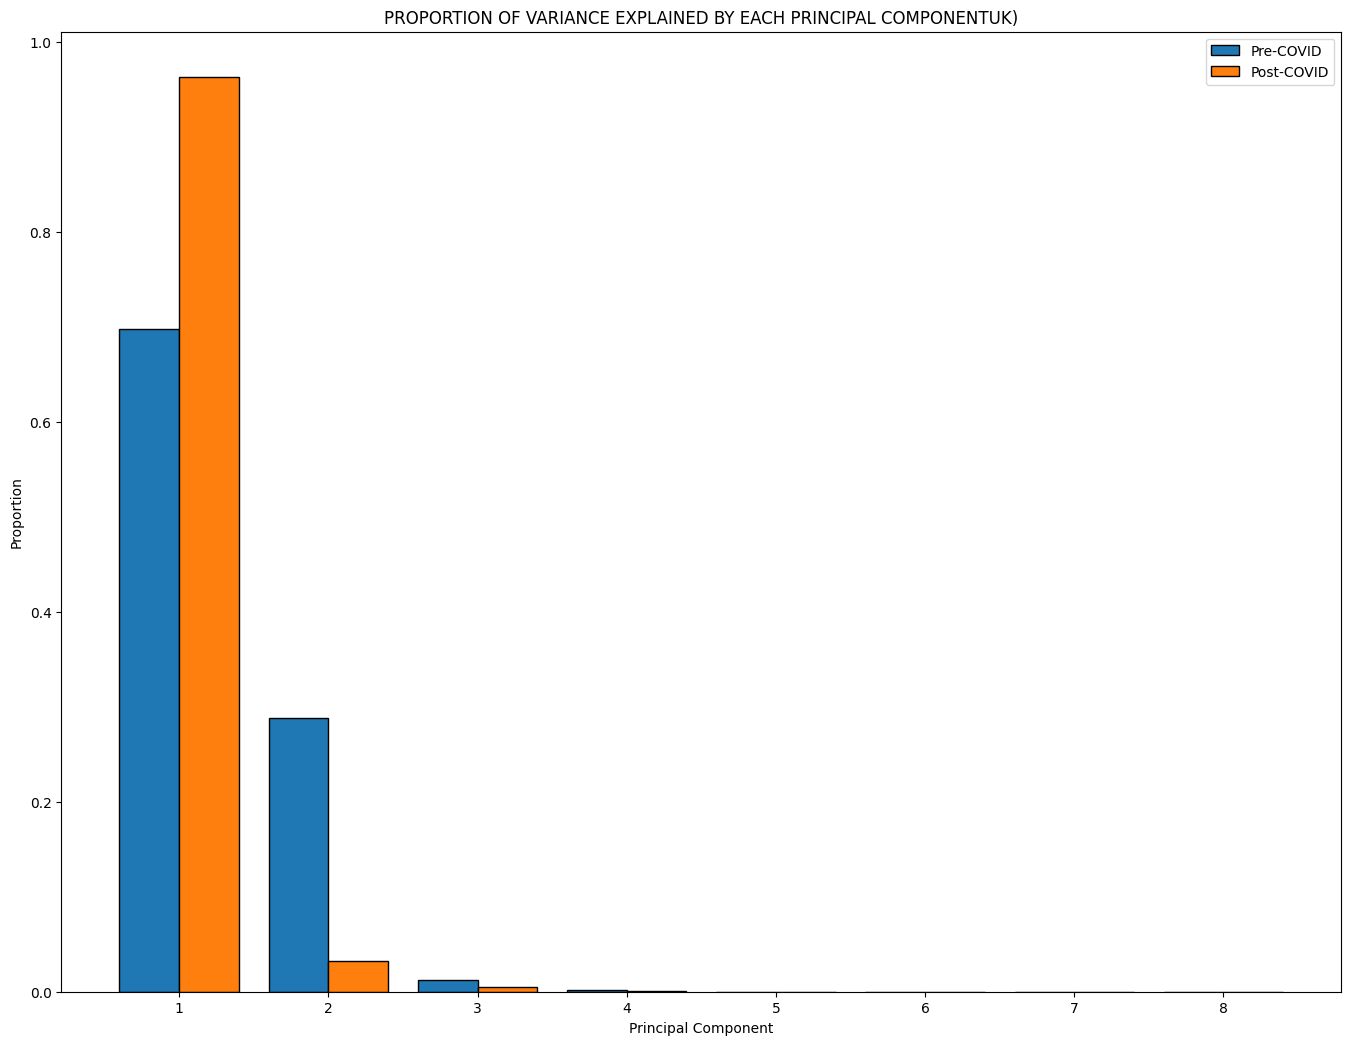

In [20]:
plot_proportion_compare(ep_uk_1['Explained Proportion'],ep_uk_2['Explained Proportion'],'uk')

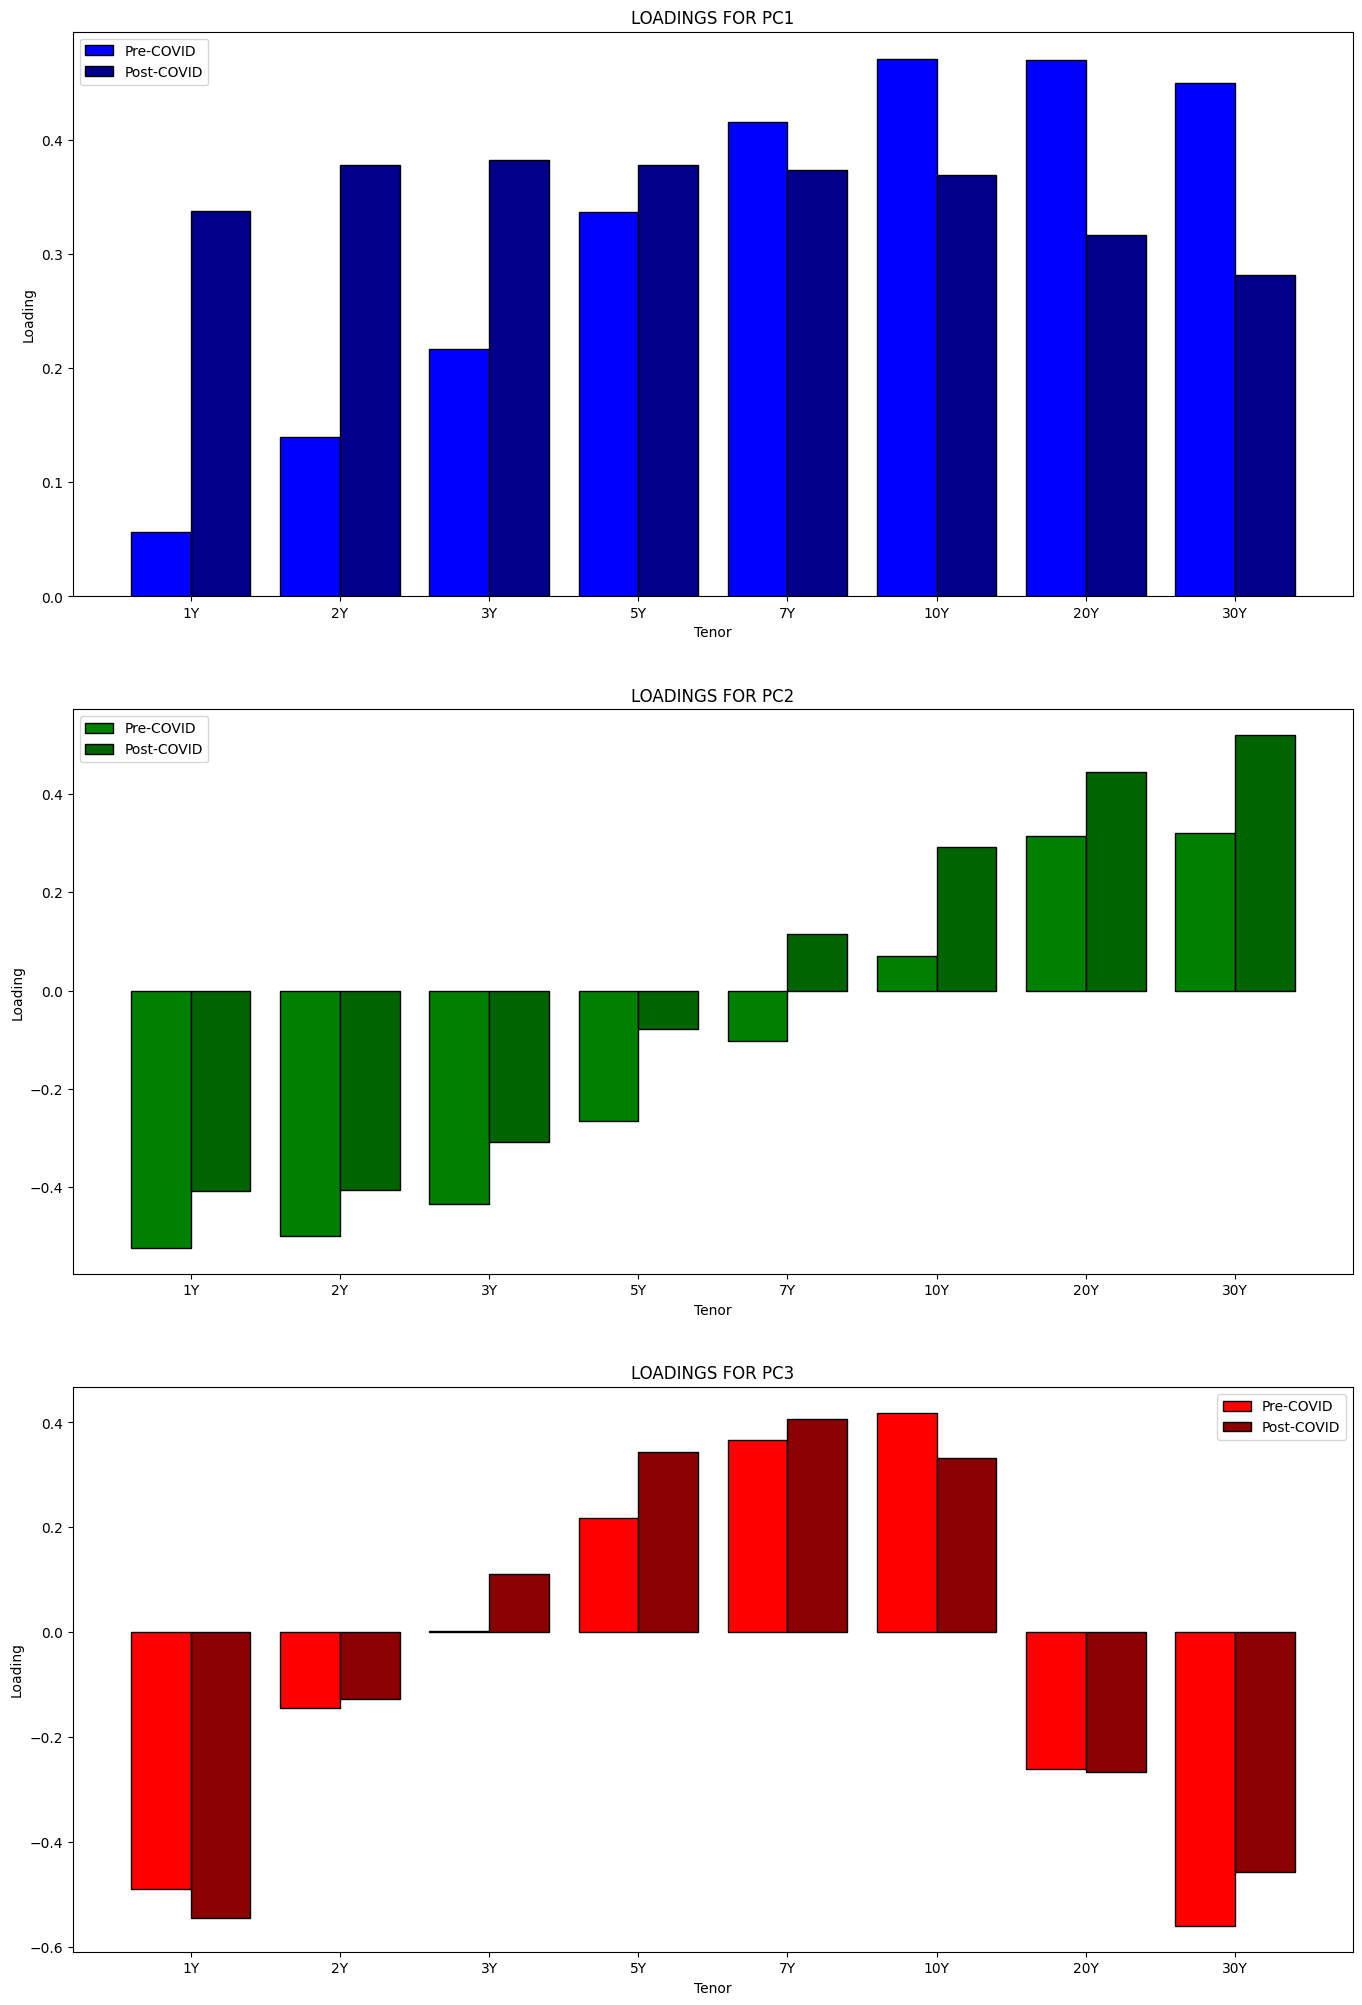

In [21]:
plot_loadings_compare(load_uk_1,load_uk_2)

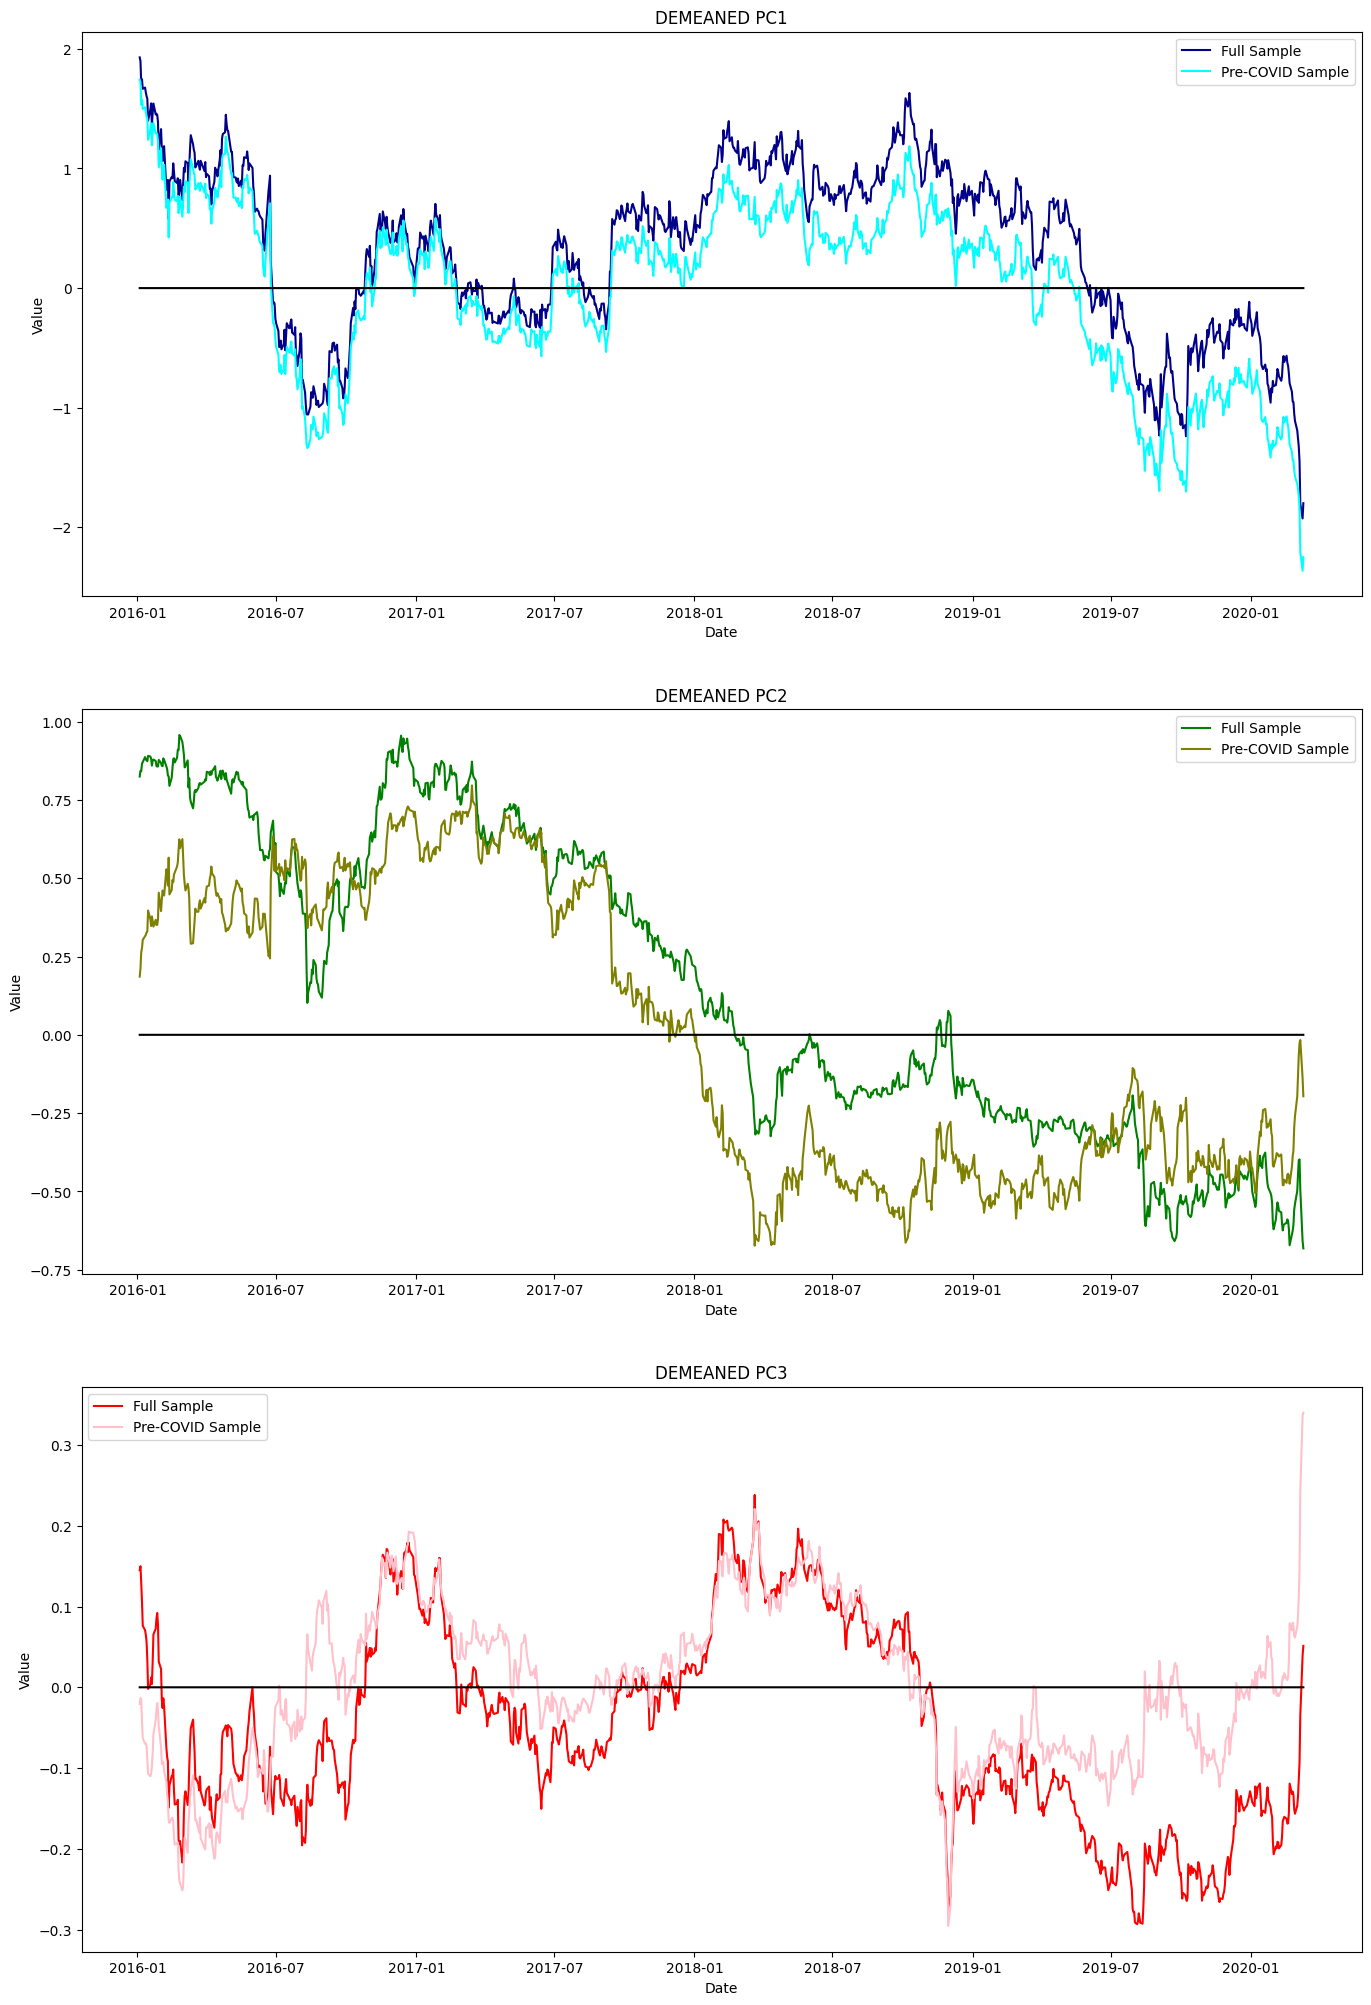

In [22]:
# comparing PC evolution of full and split sample: pre-COVID
plot_pc_compare(pc_uk_0,pc_uk_1)

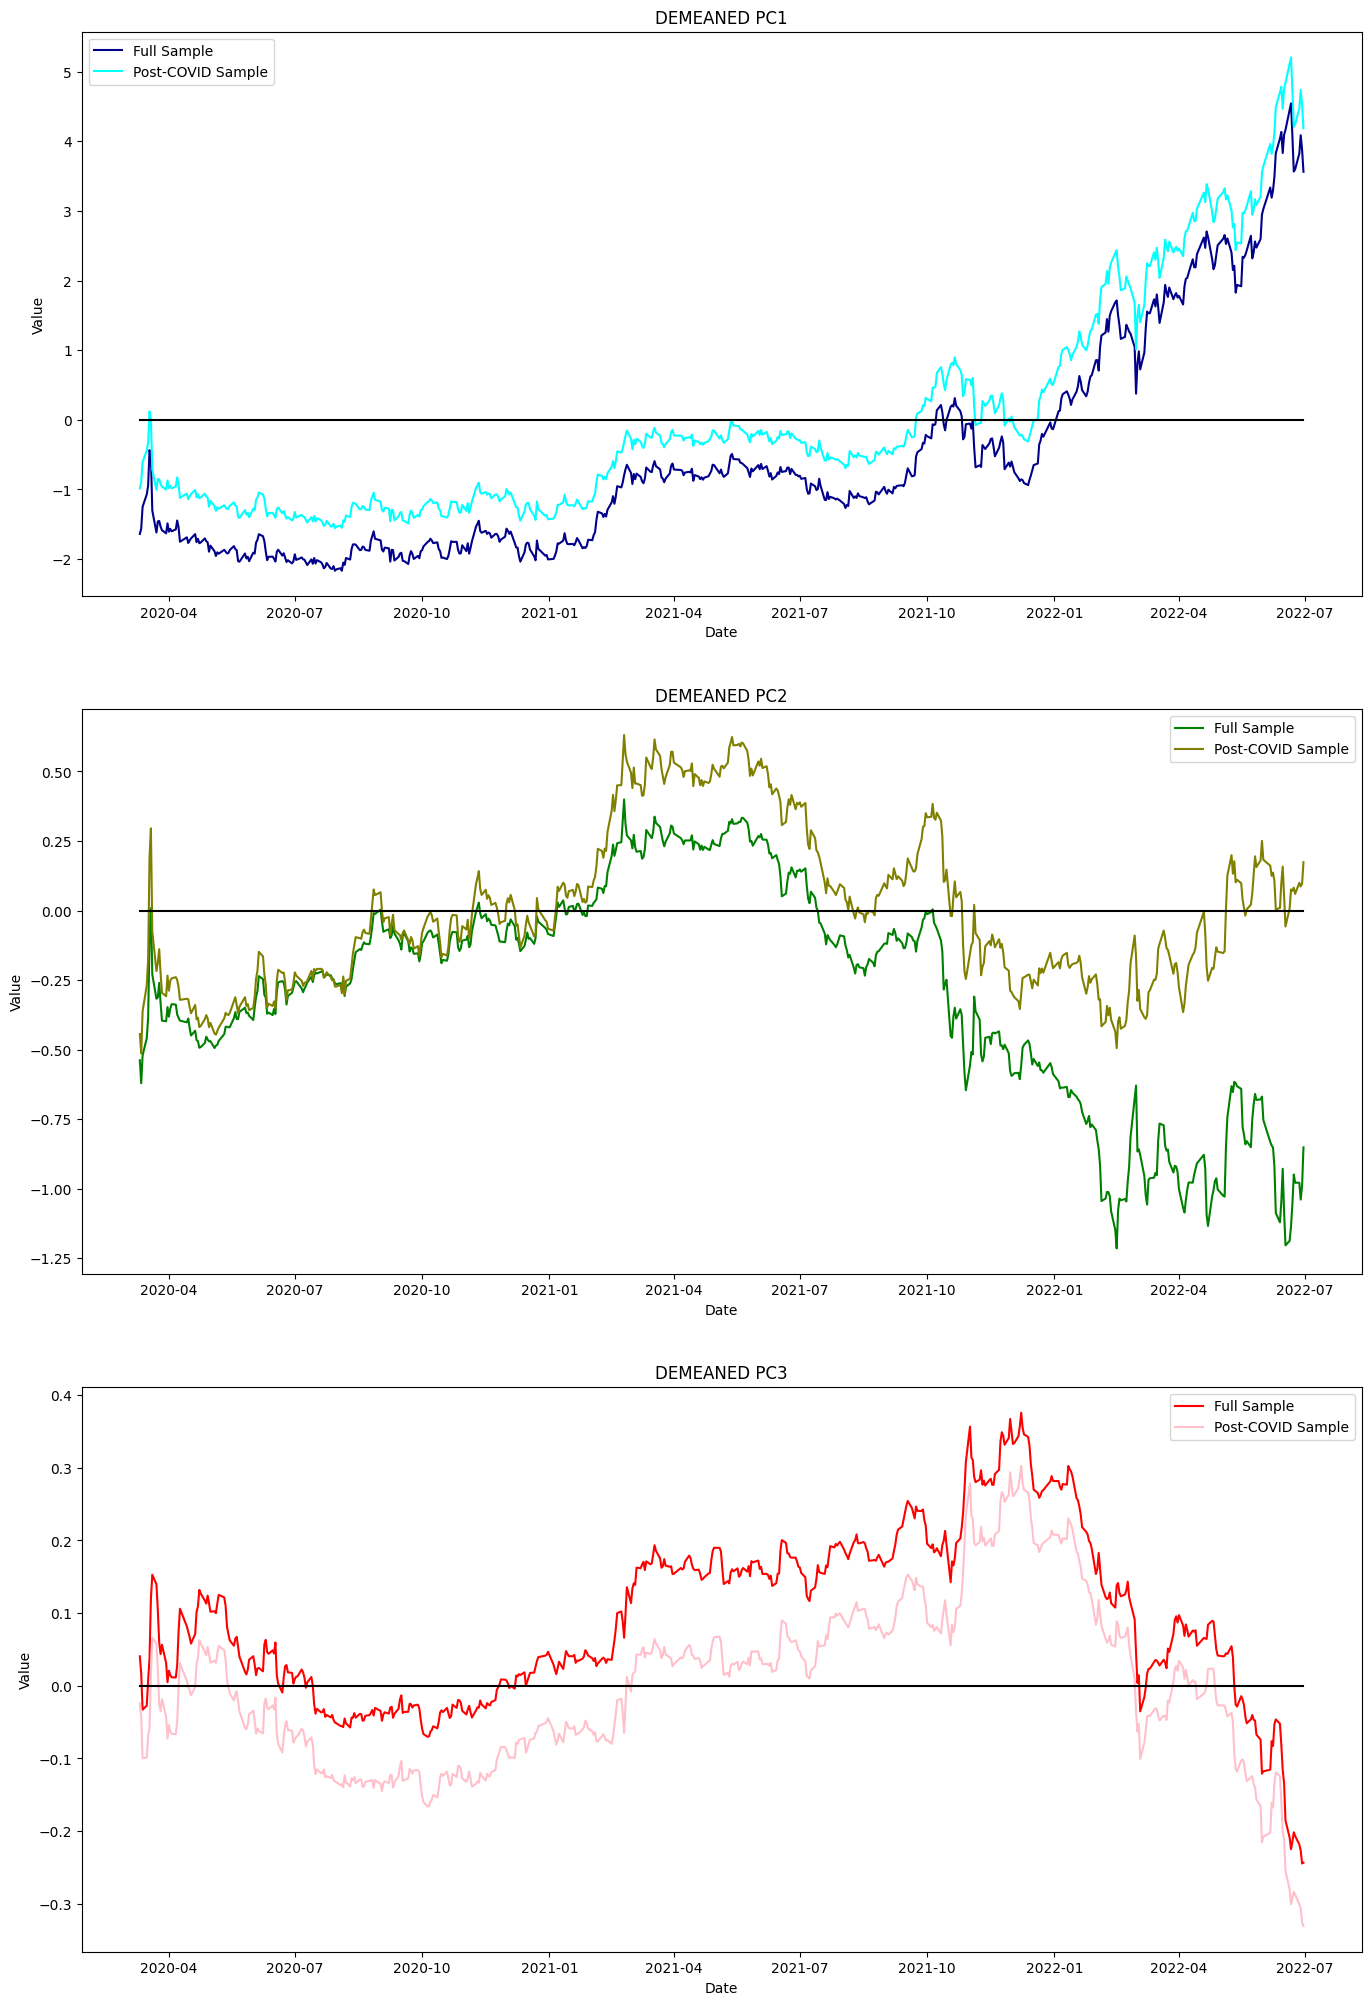

In [23]:
# comparing PC evolution of full and split sample: post-COVID
plot_pc_compare(pc_uk_0,pc_uk_2,pre = False)

Similar results as the US yield curve, but the eigenvectors seem much more unstable, since the difference in central bank action pre- and post-COVID is more stark versus US.

It appears that neither economy provides a water-tight basis for a RV PCA-based trade. Nonetheless, we explore other statistical properties of the yield curves below 

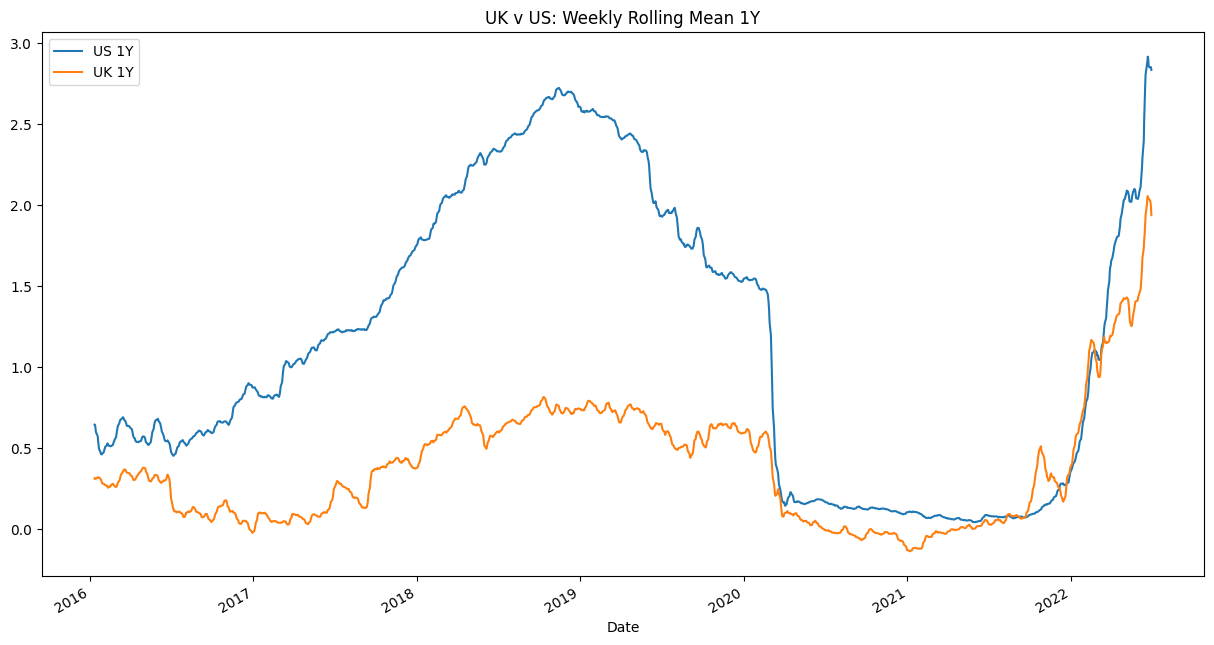

In [24]:
US['1Y'].rolling(7).mean().plot(figsize = (15,8), label = 'US 1Y')
UK['1Y'].rolling(7).mean().plot(title = 'UK v US: Weekly Rolling Mean 1Y',label = 'UK 1Y')
plt.legend();

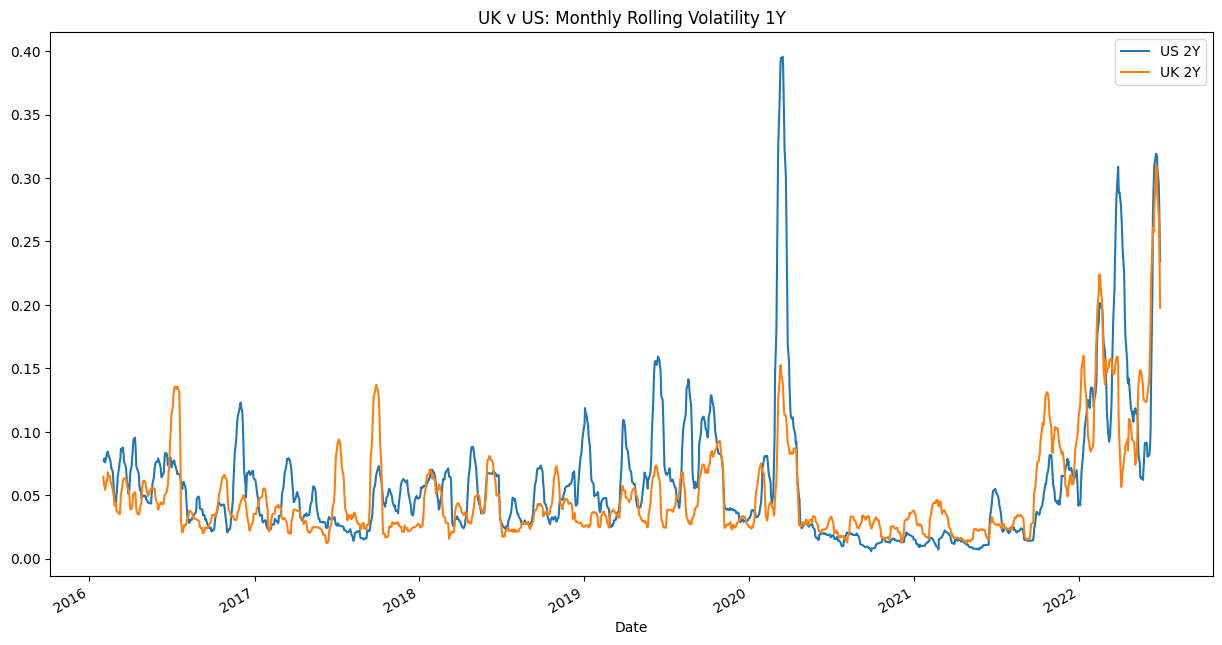

In [25]:
US['2Y'].rolling(21).std().plot(figsize = (15,8), label = 'US 2Y')
UK['2Y'].rolling(21).std().plot(title = 'UK v US: Monthly Rolling Volatility 1Y',label = 'UK 2Y')
plt.legend();

Studying the monthly rates volatility shows a few interesting facts. 
- US suffered a large spike in volatilty during the pandemic, while the UK did not have that severe a spike.
- Both markets now see to be suffering rising volatilty, which makes sense given the uncertainty about the magnitudes of hikes and the potential evolution of inflation. 
- Interestingly, UK is now suffering higher volatility than the US on the short end of the yield curve, relative to each country's inital COVID spike. This may point towards the inherent difficulties the BoE faces right now since a major component of UK inflation is food and energy (both of which are supply-side constraints), whereas inflation in the US is relatively more broad-based (relatively more dependent on demand versus UK), which means the Fed has a more 'clearer' sense of direction, so to speak.

